<a href="https://colab.research.google.com/github/KGuruPrasad94/Craft_demo/blob/main/Craft_demo_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Craft Demo - Intro

Goal: Optimize its policies and rules to accurately identify risky batches while minimizing user friction.

# **1. Import and Setup**

In [1]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import scipy as sp
import os
import random
import requests
import zipfile
import io
from datetime import timedelta

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# setting display settings to view full df
pd.set_option('display.max_columns', None)

# **2. Data Load and Exploration**

In [2]:
# load data from github
merchants_url = "https://raw.githubusercontent.com/KGuruPrasad94/Craft_demo/main/Merchant_application_data.csv"
transaction_url = "https://raw.githubusercontent.com/KGuruPrasad94/Craft_demo/main/Merchant_batch_performance_data.csv"

merchants_response = requests.get(merchants_url)
transaction_response = requests.get(transaction_url)

merchants_df = pd.read_csv(io.StringIO(merchants_response.text))
transaction_df = pd.read_csv(io.StringIO(transaction_response.text))

## 2.1 Inspecting Merchant Applications DF

In [3]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,3/5/2018
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,3/23/2016
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,6/20/2017
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,9/28/2016
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,12/3/2017


In [4]:
# inspecting shape of merchants_df
print("Dataset Dimensions: {} x {}".format(merchants_df.shape[0], merchants_df.shape[1]))

Dataset Dimensions: 15426 x 10


In [5]:
# view dataframe info
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15426 entries, 0 to 15425
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SimuID            15426 non-null  int64  
 1   MCC               15426 non-null  int64  
 2   MCCDescription    15426 non-null  object 
 3   Product           15426 non-null  object 
 4   SBG_HVC           15426 non-null  int64  
 5   AppVantageScr     15266 non-null  float64
 6   AppPublicRecords  15158 non-null  float64
 7   AppCollections    15266 non-null  float64
 8   AppAmountPastDue  15158 non-null  float64
 9   AccountOpenDate   15426 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 1.2+ MB


In [6]:
# generate descriptive statistics
merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords','AppCollections','AppAmountPastDue']].describe(include='all').T
#merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords','AppCollections','AppAmountPastDue']].describe().T

,count,mean,std,min,25%,50%,75%,max
SBG_HVC,15426.0,0.179113,0.383459,0.0,0.0,0.0,0.0,1.0
AppVantageScr,15266.0,776.616992,120.005015,0.0,687.0,775.0,865.0,990.0
AppPublicRecords,15158.0,0.173308,0.735248,0.0,0.0,0.0,0.0,19.0
AppCollections,15266.0,6.455850,269.520540,0.0,0.0,0.0,0.0,26634.0
AppAmountPastDue,15158.0,2084.486014,20613.614275,0.0,0.0,0.0,0.0,2104254.0


In [7]:
#checking for duplicate values
print(f"Number of duplicate records in dataset: {merchants_df.duplicated().sum()}")

Number of duplicate records in dataset: 0


## 2.2 Inspecting Transaction DF

In [8]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date
0,258132,Credit_Card,2.0,698.66,326.560330,237,10.1593,2,NaN,NaN,6/15/2018
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018
2,241608,ACH,2.0,622.00,0.000000,76,2.3248,6,NaN,NaN,6/11/2018
3,271779,Credit_Card,2.0,500.00,6.754413,6,113.7732,690,NaN,NaN,6/11/2018
4,261441,Credit_Card,1.0,850.00,NaN,8,-1.0000,307,NaN,NaN,5/29/2018


In [9]:
# inspecting shape of transaction_df
print("Dataset Dimensions: {} x {}".format(transaction_df.shape[0], transaction_df.shape[1]))

Dataset Dimensions: 123082 x 11


In [10]:
# view dataframe info
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123082 entries, 0 to 123081
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SimuID              123082 non-null  int64  
 1   PaymentChannel      123082 non-null  object 
 2   SaleCt              122817 non-null  float64
 3   SalesAmt            122817 non-null  float64
 4   deposit_risk_score  102384 non-null  float64
 5   PriorityScrV1       123082 non-null  int64  
 6   FinancialScoreV2    123082 non-null  float64
 7   Age                 123082 non-null  int64  
 8   ChargebackFinalAmt  412 non-null     float64
 9   ACHRtrnAmt          265 non-null     float64
 10  Batch_Clear_Date    123082 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 10.3+ MB


In [11]:
# generate descriptive statistics
transaction_df.describe(include='all').T
#transaction_df.describe().T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SimuID,123082.0,NaN,NaN,NaN,254672.643335,14300.455927,230006.0,242350.0,254584.0,267047.25,279999.0
PaymentChannel,123082,2,Credit_Card,93611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCt,122817.0,NaN,NaN,NaN,2.405734,6.394433,0.0,1.0,1.0,2.0,575.0
SalesAmt,122817.0,NaN,NaN,NaN,1393.728936,3915.532539,0.0,160.0,425.0,1230.0,350329.95
deposit_risk_score,102384.0,NaN,NaN,NaN,9.861611,92.903764,0.0,0.130725,1.183045,4.530415,10817.554
PriorityScrV1,123082.0,NaN,NaN,NaN,9051.979615,28619.98929,1.0,6.0,15.0,51.0,99999.0
FinancialScoreV2,123082.0,NaN,NaN,NaN,4.294913,21.156054,-1.0,0.4761,0.9393,2.4061,918.8972
Age,123082.0,NaN,NaN,NaN,606.060155,411.44112,-61.0,274.0,519.0,897.0,1619.0
ChargebackFinalAmt,412.0,NaN,NaN,NaN,877.561214,2115.259566,0.0,95.75,250.0,603.4875,19903.1
ACHRtrnAmt,265.0,NaN,NaN,NaN,1127.492792,2144.238474,10.0,180.0,497.23,1050.0,17566.29


In [12]:
#checking for duplicate values
print(f"Number of duplicate records in dataset: {transaction_df.duplicated().sum()}")

Number of duplicate records in dataset: 0


# **3. EDA, Outlier Treatment and Null Handling**

## 3.1 Exploring Merchants df

In [13]:
print(merchants_df['SimuID'].nunique(), len(merchants_df))

15426 15426


In [14]:
merchants_df['MCC'].value_counts()

,count
MCC,
7299,1152
8999,1078
8931,830
7399,765
7392,704
...,...
5172,1
4814,1
7519,1


In [15]:
# Product
merchants_df['Product'].value_counts()

,count
Product,
QBMS for QBO,14607
GoPayment Free,697
GoPayment,122


In [16]:
# AppCollections
merchants_df['AppCollections'].value_counts()

,count
AppCollections,
0.0,12197
1.0,1401
2.0,593
3.0,364
4.0,202
...,...
359.0,1
311.0,1
9472.0,1


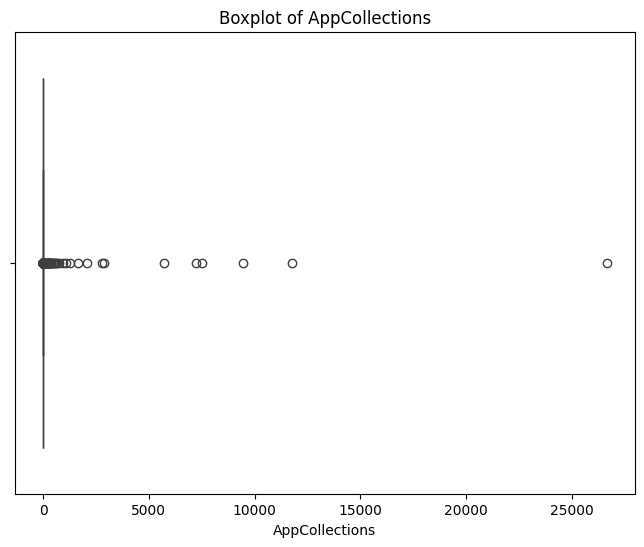

In [17]:
# Create a boxplot for AppAmountPastDue
plt.figure(figsize=(8, 6))
sns.boxplot(x=merchants_df['AppCollections'])
plt.title('Boxplot of AppCollections')
plt.xlabel('AppCollections')
plt.show()

In [18]:
# Check values greater than 15000 from AppCollections column
print("Merchants with 'AppCollections' > 15000:")
merchants_df[merchants_df['AppCollections'] >= 15000]

Merchants with 'AppCollections' > 15000:


,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
14746,277528,8099,Medical Services and Health Practitioners not ...,QBMS for QBO,0,579.0,0.0,26634.0,0.0,12/4/2016


In [19]:
# removing outlier
merchants_df = merchants_df[merchants_df['AppCollections'] <= 15000]

In [20]:
merchants_df.shape

(15265, 10)

array([[<Axes: title={'center': 'SBG_HVC'}>,
        <Axes: title={'center': 'AppVantageScr'}>],
       [<Axes: title={'center': 'AppPublicRecords'}>,
        <Axes: title={'center': 'AppAmountPastDue'}>]], dtype=object)

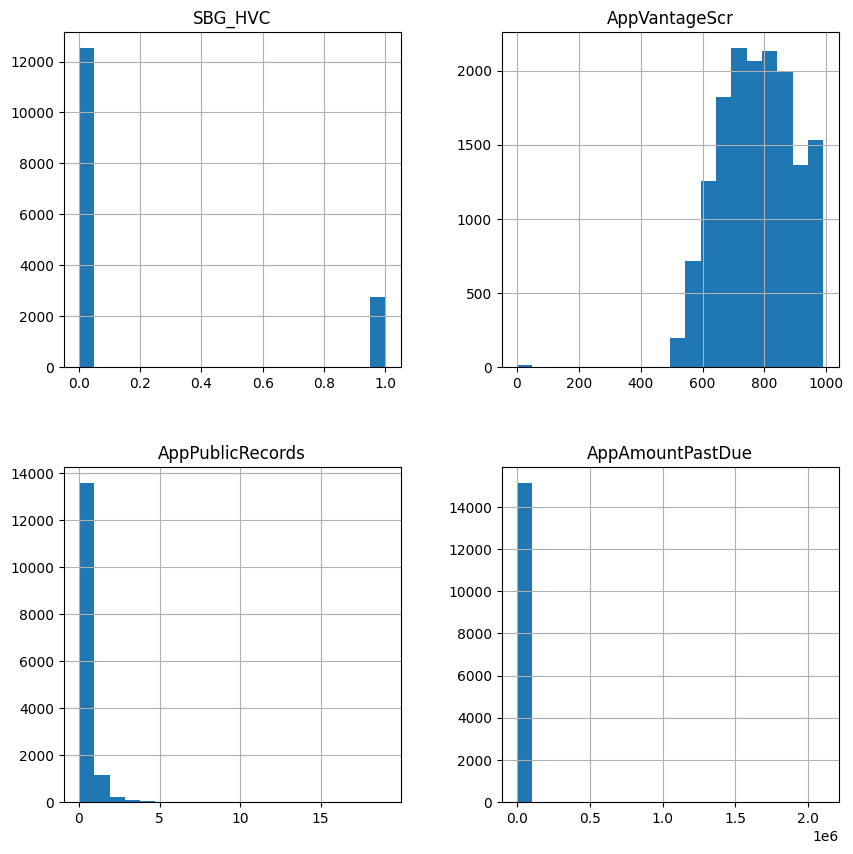

In [21]:
# checking the distribution of merchants_df columns
merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords','AppAmountPastDue']].hist(bins = 20 , figsize= (10,10))

In [22]:
# AppAmountPastDue
merchants_df['AppAmountPastDue'].value_counts()

,count
AppAmountPastDue,
0.0,11807
25.0,14
50.0,12
30.0,8
150.0,7
...,...
1664.0,1
10847.0,1
26855.0,1


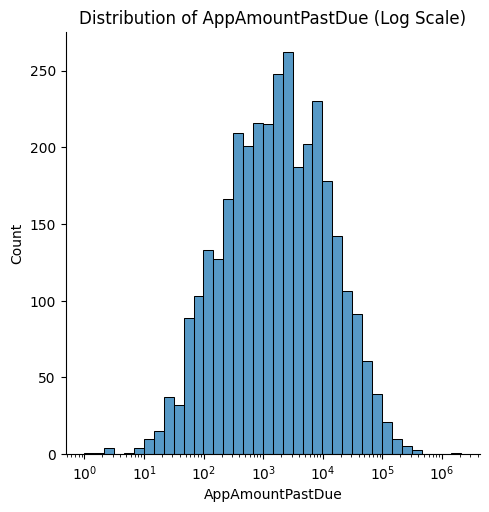

In [23]:
# checking the distribution of "AppAmountPastDue"
sns.displot(merchants_df['AppAmountPastDue'], log_scale=True)
plt.title('Distribution of AppAmountPastDue (Log Scale)')
plt.show()

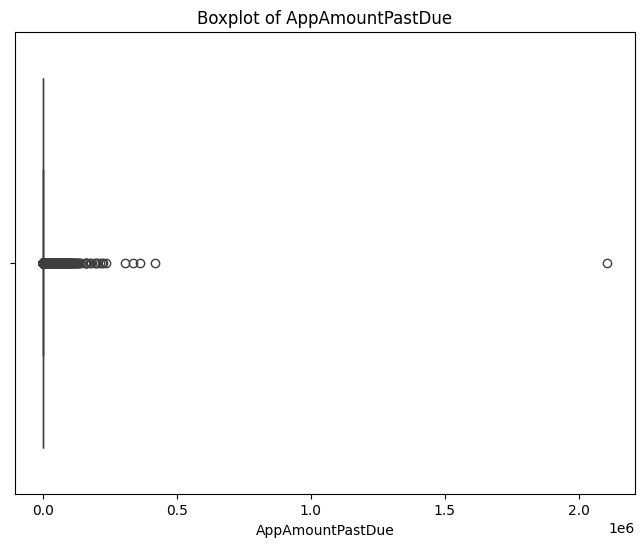

In [24]:
# Create a boxplot for AppAmountPastDue
plt.figure(figsize=(8, 6))
sns.boxplot(x=merchants_df['AppAmountPastDue'])
plt.title('Boxplot of AppAmountPastDue')
plt.xlabel('AppAmountPastDue')
plt.show()

In [25]:
# check values greater than 15000 from AppCollections column
merchants_df[merchants_df['AppAmountPastDue'] > 500000]

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
140,230425,6513,Real Estate Agents and Managers - Rentals,QBMS for QBO,0,911.0,0.0,0.0,2104254.0,3/23/2017


In [26]:
# removing outlier
merchants_df = merchants_df[merchants_df['AppAmountPastDue'] <= 500000]

In [27]:
# check values greater than 15000 from AppCollections column
merchants_df[merchants_df['AppAmountPastDue'] < 0]

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate


In [28]:
merchants_df.shape

(15156, 10)

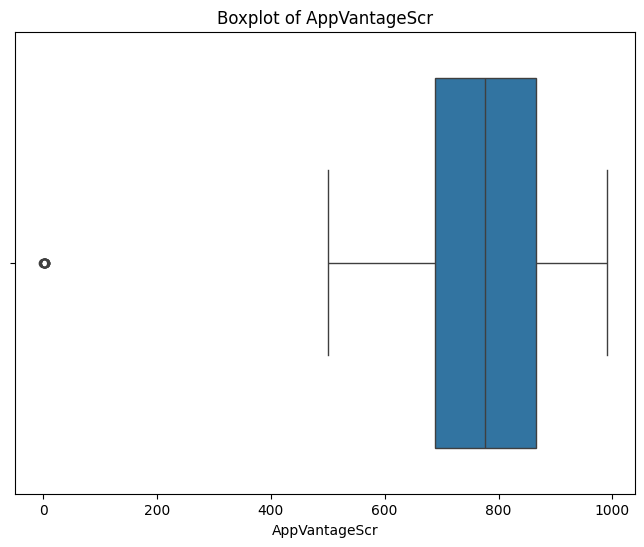

In [29]:
# create a boxplot for AppVantageScr
plt.figure(figsize=(8, 6))
sns.boxplot(x=merchants_df['AppVantageScr'])
plt.title('Boxplot of AppVantageScr')
plt.xlabel('AppVantageScr')
plt.show()

In [30]:
# check values less than 400 from AppVantageScr column
print("Merchants with 'AppVantageScr' < 400:")
len(merchants_df[merchants_df['AppVantageScr'] < 400])

Merchants with 'AppVantageScr' < 400:


9

In [31]:
# removing outlier
merchants_df = merchants_df[merchants_df['AppVantageScr'] > 400]

In [32]:
merchants_df.shape

(15131, 10)

In [33]:
merchants_df.isnull().sum()

,0
SimuID,0
MCC,0
MCCDescription,0
Product,0
SBG_HVC,0
AppVantageScr,0
AppPublicRecords,0
AppCollections,0
AppAmountPastDue,0
AccountOpenDate,0


## 3.2 Exploring Transaction df

In [34]:
print(transaction_df['SimuID'].nunique(), len(transaction_df))

15426 123082


In [35]:
# Define 'is_risky' based on ChargebackFinalAmt or ACHRtrnAmt
transaction_df['is_risky'] = ((transaction_df['ChargebackFinalAmt'].notna()) | (transaction_df['ACHRtrnAmt'].notna())).astype(int)

In [36]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
0,258132,Credit_Card,2.0,698.66,326.560330,237,10.1593,2,NaN,NaN,6/15/2018,0
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018,0
2,241608,ACH,2.0,622.00,0.000000,76,2.3248,6,NaN,NaN,6/11/2018,0
3,271779,Credit_Card,2.0,500.00,6.754413,6,113.7732,690,NaN,NaN,6/11/2018,0
4,261441,Credit_Card,1.0,850.00,NaN,8,-1.0000,307,NaN,NaN,5/29/2018,0


In [37]:
# Display the count of risky vs non-risky batches
transaction_df['is_risky'].value_counts()

,count
is_risky,
0,122405
1,677


In [38]:
# Group by PaymentChannel and is_risky and count the occurrences
payment_channel_risky_counts = transaction_df.groupby(['PaymentChannel', 'is_risky']).size().reset_index(name='count')

# Display the counts
print("Counts of PaymentChannel by Risky Status:")
display(payment_channel_risky_counts)

Counts of PaymentChannel by Risky Status:


,PaymentChannel,is_risky,count
0,ACH,0,29235
1,ACH,1,236
2,Credit_Card,0,93170
3,Credit_Card,1,441


In [39]:
chargeback_rate = 441/93170
print(f"Chargeback Rate: {chargeback_rate}")

Chargeback Rate: 0.0047332832456799395


In [40]:
ach_return_rate = 236/29235
print(f"ACH return Rate: {ach_return_rate}")

ACH return Rate: 0.008072515820078672


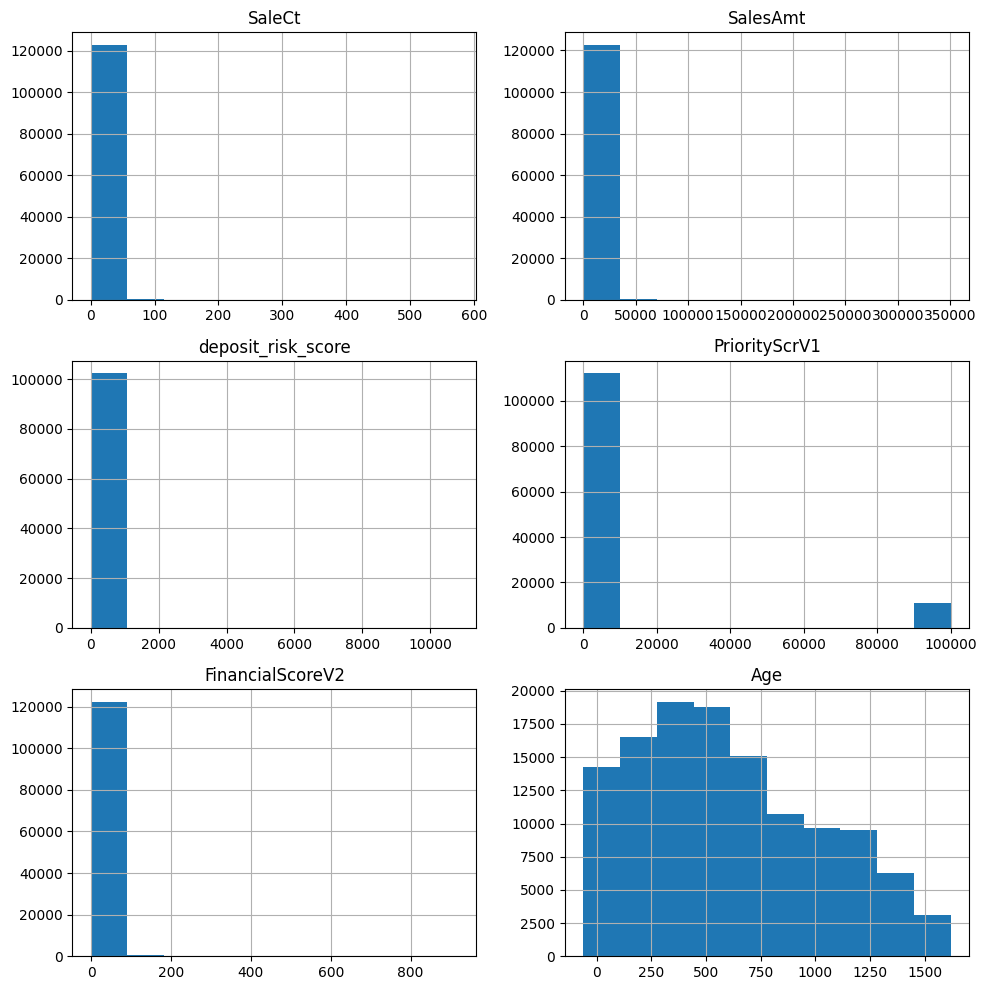

In [41]:
# checking the distribution of transaction_df columns
transaction_df[['SaleCt','SalesAmt','deposit_risk_score','PriorityScrV1','FinancialScoreV2','Age']].hist(bins = 10 , figsize= (10,10))
plt.tight_layout()
plt.show()

In [42]:
# SaleCt
transaction_df['SaleCt'].value_counts()

,count
SaleCt,
1.0,75526
2.0,21791
3.0,9084
4.0,4898
5.0,2991
...,...
211.0,1
274.0,1
281.0,1


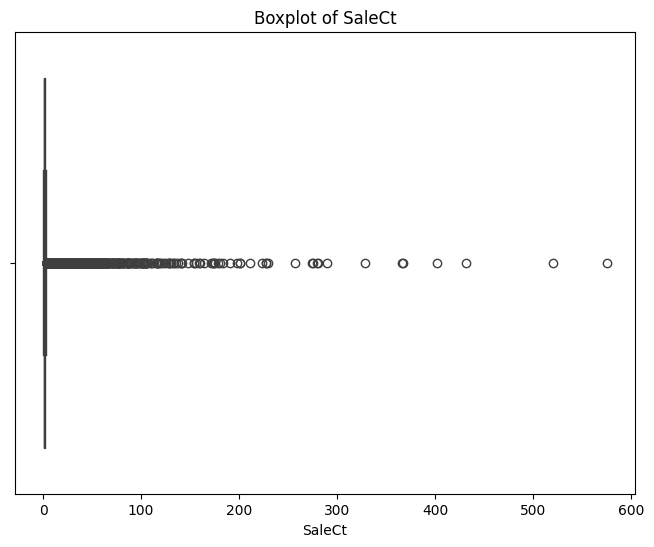

In [43]:
# Create a boxplot for SaleCt
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['SaleCt'])
plt.title('Boxplot of SaleCt')
plt.xlabel('SaleCt')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [44]:
# SaleCt
transaction_df['SalesAmt'].value_counts()

,count
SalesAmt,
100.00,1738
200.00,1429
150.00,1417
300.00,1240
250.00,1203
...,...
1082.51,1
15753.96,1
7008.78,1


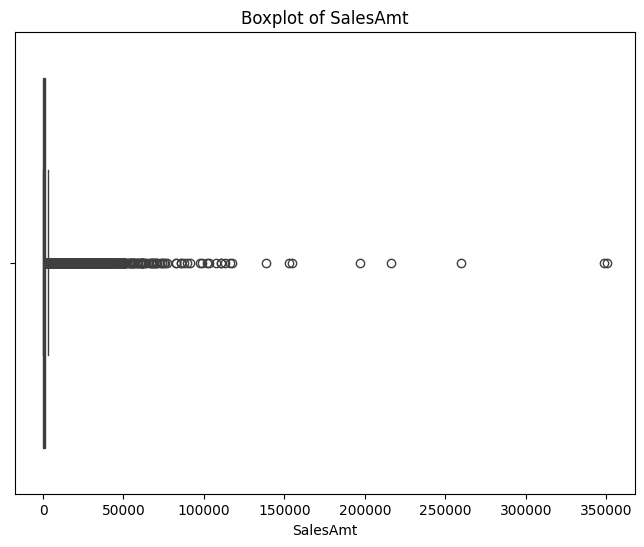

In [45]:
# Create a boxplot for SalesAmt
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['SalesAmt'])
plt.title('Boxplot of SalesAmt')
plt.xlabel('SalesAmt')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [46]:
# Check values greater than 300000 from SalesAmt column
print("Merchants with 'SalesAmt' > 300000:")
transaction_df[transaction_df['SalesAmt'] > 300000]

Merchants with 'SalesAmt' > 300000:


,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
24049,256034,ACH,13.0,348812.40,76.851786,2118,1.2641,1412,NaN,NaN,5/23/2018,0
92840,276388,Credit_Card,520.0,350329.95,NaN,5423,9.2369,305,NaN,NaN,6/1/2018,0


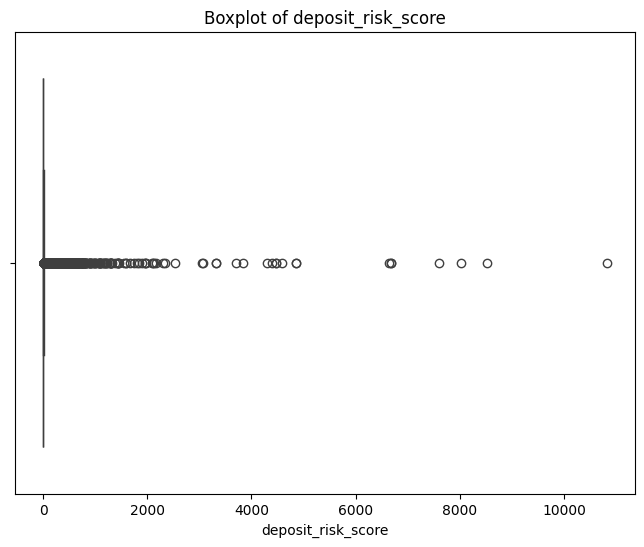

In [47]:
# Create a boxplot for deposit_risk_score
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['deposit_risk_score'])
plt.title('Boxplot of deposit_risk_score')
plt.xlabel('deposit_risk_score')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [48]:
# Check values greater than 8000 from deposit_risk_score column
print("Merchants with 'deposit_risk_score' > 8000:")
transaction_df[transaction_df['deposit_risk_score'] > 8000]

Merchants with 'deposit_risk_score' > 8000:


,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
18772,241012,Credit_Card,53.0,19337.63,10817.5540,4486,90.8357,26,NaN,NaN,6/5/2018,0
48688,241012,Credit_Card,83.0,36242.13,8019.8076,7881,36.6712,25,920.0,NaN,6/4/2018,1
97540,250934,ACH,1.0,37240.78,8520.6810,2627,2.2470,3,NaN,NaN,6/28/2018,0


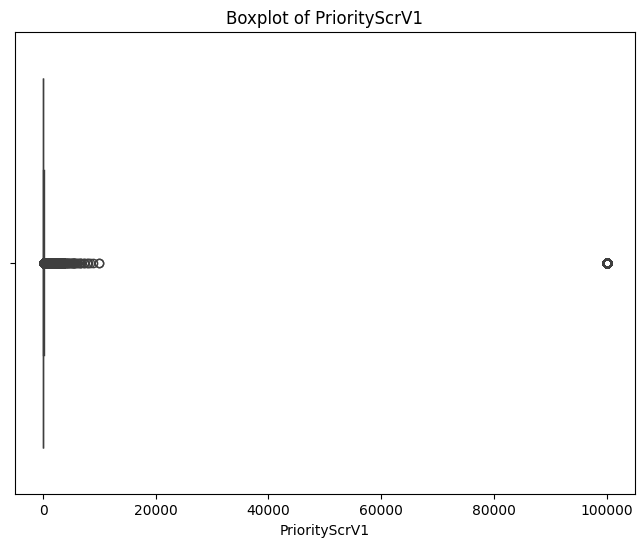

In [49]:
# Create a boxplot for PriorityScrV1
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['PriorityScrV1'])
plt.title('Boxplot of PriorityScrV1')
plt.xlabel('PriorityScrV1')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [50]:
# Check values greater than 20000 from PriorityScrV1 column
print("Merchants with 'PriorityScrV1' > 20000:")
transaction_df[transaction_df['PriorityScrV1'] > 20000]

Merchants with 'PriorityScrV1' > 20000:


,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018,0
7,273115,Credit_Card,1.0,120.00,0.000000,99999,0.5495,505,NaN,NaN,6/30/2018,0
24,245181,Credit_Card,2.0,1059.00,NaN,99999,-1.0000,978,NaN,NaN,5/26/2018,0
29,248514,Credit_Card,1.0,265.00,NaN,99999,-1.0000,1091,NaN,NaN,5/26/2018,0
31,263241,Credit_Card,1.0,735.00,18.446697,99999,5.4573,159,NaN,NaN,6/23/2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...
123041,264223,Credit_Card,1.0,200.00,0.000000,99999,171.5387,17,NaN,NaN,6/30/2018,0
123051,253412,Credit_Card,1.0,32.48,0.000000,99999,0.5152,910,NaN,NaN,5/19/2018,0
123052,252384,Credit_Card,1.0,115.00,0.119041,99999,0.3675,263,NaN,NaN,6/23/2018,0
123065,265996,Credit_Card,4.0,959.97,6.187028,99999,114.8978,690,NaN,NaN,6/30/2018,0


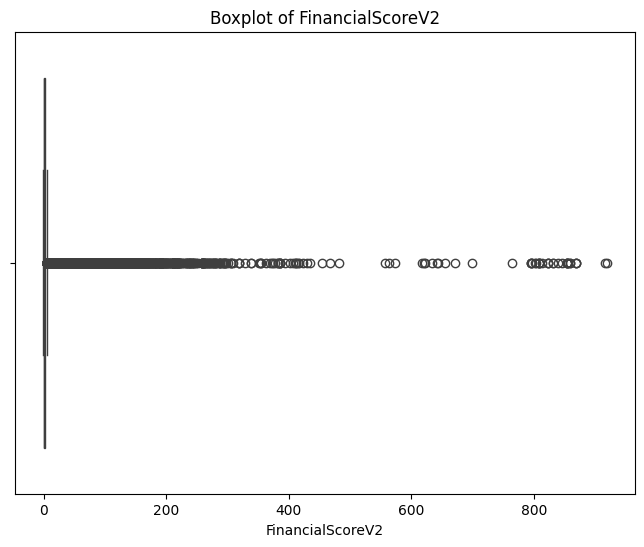

In [51]:
# Create a boxplot for FinancialScoreV2
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['FinancialScoreV2'])
plt.title('Boxplot of FinancialScoreV2')
plt.xlabel('FinancialScoreV2')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [52]:
transaction_df[transaction_df['Age']<=0]

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
43,272717,Credit_Card,1.0,1150.0,6.225272,197,7.8759,0,NaN,NaN,6/11/2018,0
500,255975,Credit_Card,1.0,1865.0,21.878944,160,7.2577,0,NaN,NaN,6/12/2018,0
558,248667,Credit_Card,1.0,151.0,NaN,71,0.5554,0,NaN,NaN,5/31/2018,0
811,265601,Credit_Card,1.0,60.0,0.000000,54,0.7267,0,NaN,NaN,6/11/2018,0
1040,230272,Credit_Card,1.0,577.0,NaN,861,25.3401,0,NaN,NaN,6/1/2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...
122068,233037,Credit_Card,1.0,1195.7,1.477098,84,2.5916,0,NaN,NaN,6/29/2018,0
122195,246287,Credit_Card,2.0,100.0,NaN,124,28.6357,0,NaN,NaN,6/1/2018,0
122333,252576,Credit_Card,1.0,55.0,0.646550,154,1.1355,0,NaN,NaN,6/13/2018,0
122999,245754,Credit_Card,1.0,410.0,0.188788,305,15.7807,0,NaN,NaN,6/7/2018,0


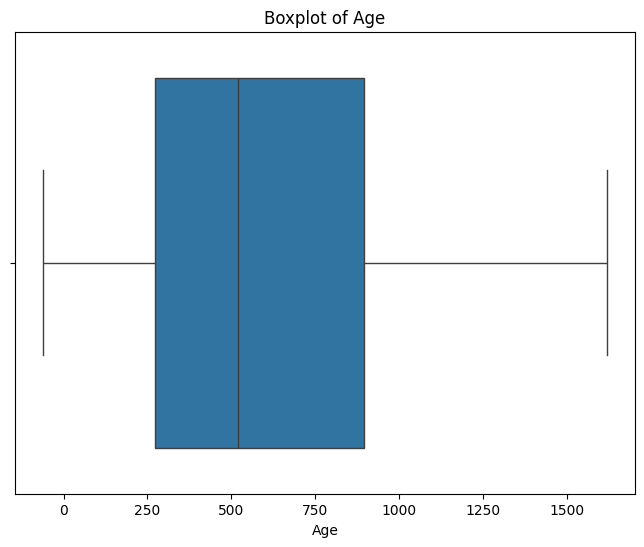

In [53]:
# Create a boxplot for Age
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['Age'])
plt.title('Boxplot of Age')
plt.xlabel('Age')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [54]:
transaction_df.shape

(123082, 12)

In [55]:
# Check for missing values in transaction_df
print("Missing values in transaction_df:")
display(transaction_df.isnull().sum())

# Check for invalid values (-1 in FinancialScoreV2, 99999 in PriorityScrV1)
financial_score_invalid_count = (transaction_df['FinancialScoreV2'] == -1).sum()
print(f"\nNumber of invalid values (-1) in FinancialScoreV2: {financial_score_invalid_count}")

priority_score_invalid_count = (transaction_df['PriorityScrV1'] == 99999).sum()
print(f"Number of invalid values (99999) in PriorityScrV1: {priority_score_invalid_count}")

Missing values in transaction_df:


,0
SimuID,0
PaymentChannel,0
SaleCt,265
SalesAmt,265
deposit_risk_score,20698
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,122670
ACHRtrnAmt,122817



Number of invalid values (-1) in FinancialScoreV2: 9292
Number of invalid values (99999) in PriorityScrV1: 11090


In [56]:
# Create indicator variables for missing/invalid values
transaction_df['deposit_risk_score_missing'] = transaction_df['deposit_risk_score'].isnull().astype(int)
transaction_df['PriorityScrV1_invalid'] = (transaction_df['PriorityScrV1'] == 99999).astype(int)
transaction_df['FinancialScoreV2_invalid'] = (transaction_df['FinancialScoreV2'] == -1).astype(int)

In [57]:
# Replace invalid values with NaN in PriorityScrV1 and FinancialScoreV2
transaction_df['PriorityScrV1'].replace(99999, np.nan, inplace=True)
transaction_df['FinancialScoreV2'].replace(-1, np.nan, inplace=True)

# Impute all missing and invalid values with -999
transaction_df['deposit_risk_score'].fillna(-999, inplace=True)
transaction_df['PriorityScrV1'].fillna(-999, inplace=True)
transaction_df['FinancialScoreV2'].fillna(-999, inplace=True)

In [58]:
# Drop rows with missing values in 'SaleCt' or 'SalesAmt'
initial_rows = transaction_df.shape[0]
transaction_df.dropna(subset=['SaleCt', 'SalesAmt'], inplace=True)
print(f"Dropped {initial_rows - transaction_df.shape[0]} rows with missing SaleCt or SalesAmt.")

# Impute missing values in 'ChargebackFinalAmt' and 'ACHRtrnAmt' with 0
transaction_df['ChargebackFinalAmt'].fillna(0, inplace=True)
transaction_df['ACHRtrnAmt'].fillna(0, inplace=True)

Dropped 265 rows with missing SaleCt or SalesAmt.


In [59]:
transaction_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [60]:
transaction_df.shape

(122817, 15)

In [61]:
transaction_df['is_chargeback'] = (transaction_df['ChargebackFinalAmt'] > 0).astype(int)
transaction_df['is_ach_return'] = (transaction_df['ACHRtrnAmt'] > 0).astype(int)

In [62]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0


# **4. Merging Dataframes and creating data buckets**

In [63]:
# Merge merchants_df and transaction_df on SimuID
merged_df = pd.merge(transaction_df, merchants_df, on='SimuID', how='inner')

# Display the first few rows of the merged dataframe
display(merged_df.head())

# Display the shape of the merged dataframe
print("\nShape of the merged dataframe:", merged_df.shape)

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017



Shape of the merged dataframe: (120466, 26)


In [64]:
merged_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [65]:
merged_df['AccountOpenDate'] = pd.to_datetime(merged_df['AccountOpenDate'])
merged_df['Batch_Clear_Date'] = pd.to_datetime(merged_df['Batch_Clear_Date'])

In [66]:
merged_df['Tenure'] = (merged_df['Batch_Clear_Date'] - merged_df['AccountOpenDate']).dt.days

In [67]:
len(merged_df[merged_df['Tenure'] <= 0])

8794

In [68]:
len(merged_df[merged_df['Age'] <= 0])

732

In [69]:
# Impute Age with -1 or -2 if age is <= 0 AND account open date != batch clear date
merged_df['Age'] = merged_df.apply(
    lambda row: -2 if row['Age'] <= 0 and row['AccountOpenDate'] != row['Batch_Clear_Date'] else row['Age'],
    axis=1
)

In [70]:
len(merged_df[merged_df['Age'] == -2])

732

**Inisght:**

Age column has -ve values, which is unusual. Calculation onf tenure from account open date and batch clear date also does not seem to be a reliable option becuase of presence of high -ve values. So, will use Age column for analysis and treat -ve age as unknown to check if there are any noticeable impact to chargeback/return rates.

In [71]:
# creating vantage score buckets
bins = [0, 550, 700, 850, 1000]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
merged_df['VantageScoreBucket'] = pd.cut(merged_df['AppVantageScr'], bins=bins, labels=labels)

In [72]:
merged_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,2017-03-30,442,Good
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,2017-08-14,278,Fair
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,2018-06-11,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,2016-04-25,777,Excellent
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,2017-09-01,283,Excellent
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,2017-08-16,286,Excellent


In [73]:
merged_df['VantageScoreBucket'].value_counts()

,count
VantageScoreBucket,
Good,49964
Excellent,35953
Fair,32312
Poor,2237


In [74]:
# creating salesamt buckets
bin_edges = [0, 500, 2500, 5000, merged_df['SalesAmt'].max() + 1]
labels = ['low_sales', 'mid_sales', 'high_sales', 'very_high_sales']

merged_df['SalesAmtBucket'] = pd.cut(
    merged_df['SalesAmt'],
    bins=bin_edges,
    labels=labels,
    include_lowest=True
)

In [75]:
# creating vantage score buckets
bins = [-1, 2, 5, 10, merged_df['SaleCt'].max()]
labels = ['0-2_sales', '2-5_sales', '6-10_sales', '10+_sales']
merged_df['SalesCtBucket'] = pd.cut(merged_df['SaleCt'], bins=bins, labels=labels)

In [76]:
merged_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket,SalesAmtBucket,SalesCtBucket
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,2017-03-30,442,Good,mid_sales,0-2_sales
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,2017-08-14,278,Fair,mid_sales,0-2_sales
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,2018-06-11,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,2016-04-25,777,Excellent,mid_sales,0-2_sales
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,2017-09-01,283,Excellent,low_sales,0-2_sales
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,2017-08-16,286,Excellent,mid_sales,0-2_sales


In [77]:
# creating age buckets
merged_df['TenureBucket'] = pd.cut(
    merged_df['Age'],
    bins=[-3, 0, 30, 90, merged_df['Age'].max()],
    labels=['Unknown','New', 'Young', 'Tenured']
)

In [78]:
merged_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,2017-03-30,442,Good,mid_sales,0-2_sales,New
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,2017-08-14,278,Fair,mid_sales,0-2_sales,Tenured
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,2018-06-11,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,2016-04-25,777,Excellent,mid_sales,0-2_sales,New
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,2017-09-01,283,Excellent,low_sales,0-2_sales,Tenured
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,2017-08-16,286,Excellent,mid_sales,0-2_sales,Tenured


In [79]:
# Create binary indicators for AppPublicRecords, AppCollections, and AppAmountPastDue
merged_df['has_public_records'] = (merged_df['AppPublicRecords'] > 0).astype(int)
merged_df['has_collections'] = (merged_df['AppCollections'] > 0).astype(int)
merged_df['has_amount_past_due'] = (merged_df['AppAmountPastDue'] > 0).astype(int)

In [ ]:
# creating AppPublicRecords buckets
merged_df['AppPublicRecords_bucket'] = pd.cut(
    merged_df['AppPublicRecords'],
    bins=[-1, 5, 10, merged_df['AppPublicRecords'].max()],
    labels=['Low_records','Medium_records', 'High_records']
)

In [80]:
# creating AppCollections buckets
merged_df['AppCollections_bucket'] = pd.cut(
    merged_df['AppCollections'],
    bins=[-1, 500, 5000, merged_df['AppCollections'].max()],
    labels=['Low_collections','Medium_collections', 'High_collections']
)

In [81]:
# creating AppAmountPastDue buckets
merged_df['AppAmountPastDue_bucket'] = pd.cut(
    merged_df['AppAmountPastDue'],
    bins=[-1, 500, 2000, merged_df['AppAmountPastDue'].max()],
    labels=['Low_pastdue','Medium_pastdue', 'High_pastdue']
)

# **5. Analysis - Chargeback and ACH Return Rate by different segments**

In [82]:
# Chargeback
cbdf = merged_df[merged_df['PaymentChannel'] == 'Credit_Card']
avg_chargeback_rate = cbdf['is_chargeback'].mean()
print(f"Avg Chargeback Rate: {avg_chargeback_rate}")

Avg Chargeback Rate: 0.0037564837564837564


In [83]:
# ACH
achdf = merged_df[merged_df['PaymentChannel'] == 'ACH']
avg_ach_return_rate = achdf['is_ach_return'].mean()
print(f"Avg ACH return Rate: {avg_ach_return_rate}")

Avg ACH return Rate: 0.006853345332456474


## 5.1 Chargeback and ACH Return rate by Tenure

In [84]:
# Risk rates across tenure
cbdf.groupby('TenureBucket')['is_chargeback'].mean()

,is_chargeback
TenureBucket,
Unknown,0.009231
New,0.004678
Young,0.003484
Tenured,0.003700


In [85]:
achdf.groupby('TenureBucket')['is_ach_return'].mean()

,is_ach_return
TenureBucket,
Unknown,0.012195
New,0.000000
Young,0.000525
Tenured,0.007596


**Insight:**

While there are some variations, the differences in chargeback and ACH return rates across 'New', 'Young', and 'Tenured' merchants are not as pronounced or consistently trending as with Sales Count or Sales Amount. New merchants have a slightly higher chargeback rate, and Tenured merchants have a higher ACH return rate, but the overall differences are relatively small.

## 5.2 Chargeback and ACH Return rate by Vantage Score

In [86]:
# Risk rates across VantageScore
cbdf.groupby('VantageScoreBucket')['is_chargeback'].mean()

,is_chargeback
VantageScoreBucket,
Poor,0.014741
Fair,0.003629
Good,0.003787
Excellent,0.003129


In [87]:
# Risk rates across tenure
achdf.groupby('VantageScoreBucket')['is_ach_return'].mean()

,is_ach_return
VantageScoreBucket,
Poor,0.007394
Fair,0.006788
Good,0.006838
Excellent,0.006893


**Insights:**

Merchants with 'Poor' Vantage Scores show a considerably higher chargeback rate compared to those with 'Fair', 'Good', or 'Excellent' scores. The trend is less clear for ACH returns across Vantage Score buckets.

## 5.3 Chargeback and ACH Return rate by Sales Amount

In [88]:
# Chargeback rate by SalesAmt bucket
cbdf.groupby('SalesAmtBucket')['is_chargeback'].mean()

,is_chargeback
SalesAmtBucket,
low_sales,0.001907
mid_sales,0.004371
high_sales,0.008566
very_high_sales,0.015456


In [89]:
# Chargeback rate by SalesAmt bucket
achdf.groupby('SalesAmtBucket')['is_ach_return'].mean()

,is_ach_return
SalesAmtBucket,
low_sales,0.003838
mid_sales,0.009051
high_sales,0.008468
very_high_sales,0.013056


**Insights:**

Batches with higher sales amounts > 5000 tend to have higher chargeback and ACH return rates.

## 5.4 Chargeback and ACH Return rate by Sales Count

In [90]:
# Chargeback rate by SalesCt bucket
cbdf.groupby('SalesCtBucket')['is_chargeback'].mean()

,is_chargeback
SalesCtBucket,
0-2_sales,0.002148
2-5_sales,0.004720
6-10_sales,0.011669
10+_sales,0.029803


In [91]:
# Chargeback rate by SalesCt bucket
achdf.groupby('SalesCtBucket')['is_ach_return'].mean()

,is_ach_return
SalesCtBucket,
0-2_sales,0.004698
2-5_sales,0.015828
6-10_sales,0.020378
10+_sales,0.047930


**Insights:**

There is a clear trend of increasing chargeback and ACH return rates as the number of sales transactions per batch increases. Batches with more sales (especially in the '6-10_sales' and '10+_sales' buckets) show significantly higher risk rates.



## 5.5 Chargeback and ACH Return rate by Tenure & Vantage Score

In [92]:
# Risk by Tenure + Vantage
pd.crosstab(cbdf['TenureBucket'], cbdf['VantageScoreBucket'], values=cbdf['is_chargeback'], aggfunc='mean')

VantageScoreBucket,Poor,Fair,Good,Excellent
TenureBucket,,,,
Unknown,0.000000,0.005618,0.003497,0.022099
New,0.000000,0.002981,0.005874,0.004110
Young,0.000000,0.001931,0.004998,0.003123
Tenured,0.015843,0.003751,0.003630,0.002957


In [93]:
# Risk by Tenure + Vantage
pd.crosstab(achdf['TenureBucket'], achdf['VantageScoreBucket'], values=achdf['is_ach_return'], aggfunc='mean')

VantageScoreBucket,Poor,Fair,Good,Excellent
TenureBucket,,,,
Unknown,NaN,0.000000,0.000000,0.166667
New,0.000000,0.000000,0.000000,0.000000
Young,0.000000,0.002309,0.000000,0.000000
Tenured,0.008753,0.007379,0.007684,0.007601


**Inisghts:**

- **Tenured + Poor Credit**  
  - Highest chargeback rate: **1.28%**  
  - ACH return rate: **0.20%**

- **Unknown Tenure + Excellent Credit**  
  - Chargeback rate: **2.14%**  
  - ACH return rate: **0.53%**  
  - Risky despite high credit — possibly synthetic or incomplete profiles

## 5.6 Chargeback and ACH Return rate by Tenure & Sales Amt

In [94]:
# Risk by Tenure + SalesAmtBucket
pd.crosstab(cbdf['TenureBucket'], cbdf['SalesAmtBucket'], values=cbdf['is_chargeback'], aggfunc='mean')

SalesAmtBucket,low_sales,mid_sales,high_sales,very_high_sales
TenureBucket,,,,
Unknown,0.005780,0.009524,0.035714,0.000000
New,0.003133,0.005721,0.000000,0.024194
Young,0.002431,0.003783,0.014286,0.000000
Tenured,0.001800,0.004321,0.008227,0.016269


In [95]:
# Risk by Tenure + SalesAmtBucket
pd.crosstab(achdf['TenureBucket'], achdf['SalesAmtBucket'], values=achdf['is_ach_return'], aggfunc='mean')

SalesAmtBucket,low_sales,mid_sales,high_sales,very_high_sales
TenureBucket,,,,
Unknown,0.000000,0.000000,0.000000,0.25000
New,0.000000,0.000000,0.000000,0.00000
Young,0.001001,0.000000,0.000000,0.00000
Tenured,0.004256,0.010058,0.009471,0.01397


**Insights:**

- **Unknown + High Sales**  
  - Chargeback rate: **2.94%**   
  - Very high chargeback risk — likely insufficient tenure verification for high-dollar merchants

- **Unknown + Very High Sales**  
  - ACH return rate: **2.38%**   
  - Highest ACH return risk — possibly incomplete onboarding

- **New + Very High Sales**  
  - Chargeback rate: **1.32%**  
  - Elevated fraud risk despite recent onboarding — warrants early monitoring

## 5.6 Chargeback and ACH Return rate by Tenure & Sales Count

In [96]:
# Risk by Tenure + SalesCtBucket
pd.crosstab(cbdf['TenureBucket'], cbdf['SalesCtBucket'], values=cbdf['is_chargeback'], aggfunc='mean')

SalesCtBucket,0-2_sales,2-5_sales,6-10_sales,10+_sales
TenureBucket,,,,
Unknown,0.009677,0.000000,0.000000,0.000000
New,0.003412,0.006993,0.000000,0.061224
Young,0.002230,0.004673,0.004695,0.044248
Tenured,0.002021,0.004680,0.012305,0.028473


In [97]:
# Risk by Tenure + SalesCtBucket
pd.crosstab(achdf['TenureBucket'], achdf['SalesCtBucket'], values=achdf['is_ach_return'], aggfunc='mean')

SalesCtBucket,0-2_sales,2-5_sales,6-10_sales,10+_sales
TenureBucket,,,,
Unknown,0.021739,0.000000,0.000000,0.00000
New,0.000000,0.000000,0.000000,0.00000
Young,0.000582,0.000000,0.000000,0.00000
Tenured,0.005202,0.017007,0.021841,0.05379


**Insights:**

- **New & 10+ Sales**  
  - Chargeback rate: **5.66%**  
  - ACH return rate: **0.00%**  
  - Significant chargeback risk from new merchants with high volume – potential fraud or inadequate vetting

- **Young & 10+ Sales**  
  - Chargeback rate: **3.77%**  
  - ACH return rate: **0.00%**  
  - Early-tenure merchants with high sales volume also show elevated chargebacks

- **Tenured & 10+ Sales**  
  - Chargeback rate: **2.49%**, ACH return: **1.25%**  
  - Still shows notable risk—high volume always warrants close monitoring

## 5.7 Chargeback and ACH Return rate by Merchant Categories

In [98]:
cbdf.groupby(['MCC','MCCDescription'])['is_chargeback'].mean().sort_values(ascending=False).head(10)

,,is_chargeback
MCC,MCCDescription,
5976,Orthopedic Goods - Prosthetic Devices,0.142857
7641,"Reupholstery and Furniture Repair, Furniture Refinishing",0.095238
5571,Motorcycle Shops and Dealers,0.090909
5074,Plumbing and Heating Equipment,0.052632
7395,"Photofinishing Laboratories, Photo Developing",0.052632
5200,Home Supply Warehouse,0.033333
7622,Electronic Repair Shops,0.029412
7230,Beauty Shops and Barber Shops,0.027944
5331,Variety Stores,0.023810


In [99]:
achdf.groupby(['MCC','MCCDescription'])['is_ach_return'].mean().sort_values(ascending=False).head(10)

,,is_ach_return
MCC,MCCDescription,
8049,"Chiropodists, Podiatrists",0.125000
5947,"Gift, Card, Novelty, and Souvenir Shops",0.078947
5137,"Men's, Women's, and Children's Uniforms and Commercial Clothing",0.071429
8050,Nursing and Personal Care Facilities,0.060000
5021,Office and Commercial Furniture,0.045455
5499,"Miscellaneous Food Stores - Specialty Stores, Markets, Convenience Stores, and Vending Machines",0.042017
7217,Carpet and Upholstery Cleaning,0.029412
4121,Taxicabs/ Limousines,0.023810
5714,"Drapery, Upholstery, and Window Coverings Stores",0.021739


**Insights:**

Some merchant categories appear to have notably higher chargeback or ACH return rates than others. This suggests that the type of business can be a risk factor

## 5.8 Chargeback and ACH Return rate by HVC

In [100]:
# Risk rates by SBG_HVC
cbdf.groupby('SBG_HVC')['is_chargeback'].mean()

,is_chargeback
SBG_HVC,
0,0.003824
1,0.003449


In [101]:
# Risk rates by SBG_HVC
achdf.groupby('SBG_HVC')['is_ach_return'].mean()

,is_ach_return
SBG_HVC,
0,0.007025
1,0.006109


**Insights:**

There is a very small difference in chargeback and ACH return rates between HVC (High-Value Customer) and non-HVC merchants, with HVC merchants showing slightly lower rates.

## 5.9 Chargeback and ACH Return rate by has_public_records

In [102]:
cbdf.groupby('has_public_records')['is_chargeback'].mean()

,is_chargeback
has_public_records,
0,0.003839
1,0.003066


In [103]:
achdf.groupby('has_public_records')['is_ach_return'].mean()

,is_ach_return
has_public_records,
0,0.006888
1,0.006560


**Insights:**

Merchants with public records do not show a consistently higher chargeback or ACH return rate; the relationship appears weak or even slightly inverse based on the binary indicator.

## 5.10 Chargeback and ACH Return rate by has_collections

In [104]:
cbdf.groupby('has_collections')['is_chargeback'].mean()

,is_chargeback
has_collections,
0,0.003406
1,0.005174


In [105]:
achdf.groupby('has_collections')['is_ach_return'].mean()

,is_ach_return
has_collections,
0,0.006985
1,0.006348


**Insights:**

Merchants with a history of collections ('has_collections' = 1) have a higher chargeback rate compared to those without collections

## 5.11 Chargeback and ACH Return rate by has_amount_past_due


In [106]:
cbdf.groupby('has_amount_past_due')['is_chargeback'].mean()

,is_chargeback
has_amount_past_due,
0,0.003263
1,0.005501


In [107]:
achdf.groupby('has_amount_past_due')['is_ach_return'].mean()

,is_ach_return
has_amount_past_due,
0,0.006933
1,0.006572


**Insights:**

Merchants with any amount past due ('has_amount_past_due' = 1) also show a higher chargeback rate compared to those without.

## 5.12 Chargeback and ACH Return rate by deposit_risk_score_missing

In [108]:
cbdf.groupby('deposit_risk_score_missing')['is_chargeback'].mean()

,is_chargeback
deposit_risk_score_missing,
0,0.003724
1,0.003916


In [109]:
achdf.groupby('deposit_risk_score_missing')['is_ach_return'].mean()

,is_ach_return
deposit_risk_score_missing,
0,0.006528
1,0.008534


**Inisghts:**

Batches where the deposit_risk_score was missing showed a slightly higher proportion of risky batches.

## 5.13 Chargeback and ACH Return rate by PriorityScrV1_invalid

In [110]:
cbdf.groupby('PriorityScrV1_invalid')['is_chargeback'].mean()

,is_chargeback
PriorityScrV1_invalid,
0,0.003953
1,0.002029


In [111]:
achdf.groupby('PriorityScrV1_invalid')['is_ach_return'].mean()

,is_ach_return
PriorityScrV1_invalid,
0,0.006759
1,0.008547


**Insights:**

Interestingly, batches with the invalid PriorityScrV1 value showed a lower proportion of risky batches.

## 5.14 Chargeback and ACH Return rate by FinancialScoreV2_invalid

In [112]:
cbdf.groupby('FinancialScoreV2_invalid')['is_chargeback'].mean()

,is_chargeback
FinancialScoreV2_invalid,
0,0.003769
1,0.003613


In [113]:
achdf.groupby('FinancialScoreV2_invalid')['is_ach_return'].mean()

,is_ach_return
FinancialScoreV2_invalid,
0,0.006853
1,0.006864


**Insights:**

The invalid FinancialScoreV2 value (-1) did not show a notable difference in the proportion of risky batches.

# **6. Aggregation and Feature Engineering**

## 6.1 Aggregating transaction level features to merchant df

In [114]:
# Aggregate transaction data to the merchant level
merchant_agg_df = transaction_df.groupby('SimuID').agg(
    total_sales_amount=('SalesAmt', 'sum'),
    total_sale_count=('SaleCt', 'sum'),
    average_sales_amount=('SalesAmt', 'mean'),
    average_sale_count=('SaleCt', 'mean'),
    total_chargeback_amount=('ChargebackFinalAmt', 'sum'),
    total_ach_return_amount=('ACHRtrnAmt', 'sum'),
    total_risky_batches=('is_risky', 'sum'),
    batch_count=('SimuID', 'count'),
    risky_batch_count=('is_risky', lambda x: (x > 0).sum()) # Count of batch where is_risky is 1
).reset_index()

merchants_df = pd.merge(merchants_df, merchant_agg_df, on='SimuID', how='left')

# Display the shape of the updated merchants_df
print("\nShape of merchants_df after merging:", merchants_df.shape)


Shape of merchants_df after merging: (15131, 19)


In [ ]:
merchants_df.head()

In [115]:
merged_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


## 6.2 Calculating historical chargeback rate and ACH rate per merchant

In [116]:
# Chargeback rate from cb_df
cb_agg = cbdf.groupby('SimuID').agg(
    total_cb_amt=('ChargebackFinalAmt', 'sum'),
    total_cb_sales=('SalesAmt', 'sum')
).reset_index()
cb_agg['chargeback_amt_rate'] = cb_agg['total_cb_amt'] / cb_agg['total_cb_sales']
cb_agg['chargeback_amt_rate'].fillna(0, inplace=True)
cb_agg.loc[cb_agg['total_cb_sales'] == 0, 'chargeback_amt_rate'] = 0

# ACH return rate from ach_df
ach_agg = achdf.groupby('SimuID').agg(
    total_ach_amt=('ACHRtrnAmt', 'sum'),
    total_ach_sales=('SalesAmt', 'sum')
).reset_index()
ach_agg['ach_amt_return_rate'] = ach_agg['total_ach_amt'] / ach_agg['total_ach_sales']
ach_agg['ach_amt_return_rate'].fillna(0, inplace=True)
ach_agg.loc[ach_agg['total_ach_sales'] == 0, 'ach_amt_return_rate'] = 0

# Merge back into master merchant df
merchants_df = merchants_df.merge(cb_agg[['SimuID', 'chargeback_amt_rate']], on='SimuID', how='left')
merchants_df = merchants_df.merge(ach_agg[['SimuID', 'ach_amt_return_rate']], on='SimuID', how='left')

In [117]:
merchants_df['ach_amt_return_rate'].fillna(0, inplace=True)
merchants_df['chargeback_amt_rate'].fillna(0, inplace=True)

In [118]:
merchants_df['risky_batch_rate'] = merchants_df['risky_batch_count'] / merchants_df['batch_count']
merchants_df['risky_batch_rate'].fillna(0, inplace=True)

In [119]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,average_sale_count,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,3/5/2018,9000.00,4.0,3000.000000,1.333333,0.0,0.0,0,3,0,0.0,0.0,0.0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,3/23/2016,3292.50,14.0,299.318182,1.272727,0.0,0.0,0,11,0,0.0,0.0,0.0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,6/20/2017,20420.41,50.0,729.300357,1.785714,0.0,0.0,0,28,0,0.0,0.0,0.0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,9/28/2016,17502.88,2.0,8751.440000,1.000000,0.0,0.0,0,2,0,0.0,0.0,0.0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,12/3/2017,4304.60,7.0,717.433333,1.166667,0.0,0.0,0,6,0,0.0,0.0,0.0





## 6.3 Calculating recency features

In [120]:
# Ensure date columns are in datetime format
merchants_df['AccountOpenDate'] = pd.to_datetime(merchants_df['AccountOpenDate'])
transaction_df['Batch_Clear_Date'] = pd.to_datetime(transaction_df['Batch_Clear_Date'])

# Define a reference date (e.g., the latest batch clear date in the dataset)
reference_date = transaction_df['Batch_Clear_Date'].max()

In [121]:
# Calculate recency of last batch for each merchant
last_batch_dates = transaction_df.groupby('SimuID')['Batch_Clear_Date'].max().reset_index()
last_batch_dates.rename(columns={'Batch_Clear_Date': 'latest_batch_clear_date'}, inplace=True)
merchants_df = pd.merge(merchants_df, last_batch_dates, on='SimuID', how='left')
merchants_df['recency_last_batch'] = (reference_date - merchants_df['latest_batch_clear_date']).dt.days.fillna(9999) # Fill NaN for merchants with no transactions


In [122]:
# Calculate recency of last risky batch for each merchant
risky_transactions = transaction_df[transaction_df['is_risky'] == 1]
last_risky_batch_dates = risky_transactions.groupby('SimuID')['Batch_Clear_Date'].max().reset_index()
last_risky_batch_dates.rename(columns={'Batch_Clear_Date': 'last_risky_batch_date'}, inplace=True)
merchants_df = pd.merge(merchants_df, last_risky_batch_dates, on='SimuID', how='left')
merchants_df['recency_last_risky_batch'] = (reference_date - merchants_df['last_risky_batch_date']).dt.days.fillna(9999) # Fill NaN for merchants with no risky transactions

In [123]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,average_sale_count,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,2018-03-05,9000.00,4.0,3000.000000,1.333333,0.0,0.0,0,3,0,0.0,0.0,0.0,2018-06-28,2,NaT,9999.0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,2016-03-23,3292.50,14.0,299.318182,1.272727,0.0,0.0,0,11,0,0.0,0.0,0.0,2018-06-18,12,NaT,9999.0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,2017-06-20,20420.41,50.0,729.300357,1.785714,0.0,0.0,0,28,0,0.0,0.0,0.0,2018-06-29,1,NaT,9999.0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,2016-09-28,17502.88,2.0,8751.440000,1.000000,0.0,0.0,0,2,0,0.0,0.0,0.0,2018-06-12,18,NaT,9999.0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,2017-12-03,4304.60,7.0,717.433333,1.166667,0.0,0.0,0,6,0,0.0,0.0,0.0,2018-06-23,7,NaT,9999.0



## 6.4 Calculating high risk merchants

In [124]:
#calculate chargeback rate and ach return rate for each merchant
merchant_cb = cbdf.groupby(['SimuID', 'MCC']).agg(
    cb_batch_rate=('is_chargeback', 'mean'),
    cb_batch_count=('is_chargeback', 'count')
).reset_index()

merchant_ach = achdf.groupby(['SimuID', 'MCC']).agg(
    ach_batch_return_rate=('is_ach_return', 'mean'),
    ach_batch_count=('is_ach_return', 'count')
).reset_index()

In [125]:
#calculate avg chargeback rate and ach return rate for each mcc

mcc_cb = cbdf.groupby('MCC').agg(
    mcc_cb_rate=('is_chargeback', 'mean')
).reset_index()

mcc_ach = achdf.groupby('MCC').agg(
    mcc_ach_rate=('is_ach_return', 'mean')
).reset_index()

In [126]:
merchant_cb = pd.merge(merchant_cb, mcc_cb, on='MCC', how='left')
merchant_ach = pd.merge(merchant_ach, mcc_ach, on='MCC', how='left')

In [127]:
# high risk if merchant cb/ach rate > avg mcc cb/ach rate (comparing merchant rate to their mcc rate)
merchant_cb['cb_high_risk'] = (
    (merchant_cb['cb_batch_rate'] > merchant_cb['mcc_cb_rate']) &
    (merchant_cb['cb_batch_count'] >= 10)
).astype(int)

merchant_ach['ach_high_risk'] = (
    (merchant_ach['ach_batch_return_rate'] > merchant_ach['mcc_ach_rate']) &
    (merchant_ach['ach_batch_count'] >= 10)
).astype(int)

In [128]:
# calc is_high_risk merchant
merchant_risk = pd.merge(
    merchant_cb[['SimuID', 'cb_high_risk']],
    merchant_ach[['SimuID', 'ach_high_risk']],
    on='SimuID',
    how='outer'
).fillna(0)

merchant_risk['is_high_risk_merchant'] = (
    (merchant_risk['cb_high_risk'] == 1) |
    (merchant_risk['ach_high_risk'] == 1)
).astype(int)

In [129]:
merchant_risk.shape

(15131, 4)

In [130]:
merchant_risk['is_high_risk_merchant'].value_counts()

,count
is_high_risk_merchant,
0,14878
1,253


In [131]:
# Merge merchant-level risk flags into your merchants_df
merchants_df = pd.merge(
    merchants_df,
    merchant_risk[['SimuID', 'cb_high_risk', 'ach_high_risk', 'is_high_risk_merchant']],
    on='SimuID',
    how='left'
)

# Fill any NaNs in the new risk columns with 0 (e.g., if merchant had no CB/ACH activity)
merchants_df[['cb_high_risk', 'ach_high_risk', 'is_high_risk_merchant']] = merchants_df[[
    'cb_high_risk', 'ach_high_risk', 'is_high_risk_merchant'
]].fillna(0).astype(int)

In [132]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,average_sale_count,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,cb_high_risk,ach_high_risk,is_high_risk_merchant
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,2018-03-05,9000.00,4.0,3000.000000,1.333333,0.0,0.0,0,3,0,0.0,0.0,0.0,2018-06-28,2,NaT,9999.0,0,0,0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,2016-03-23,3292.50,14.0,299.318182,1.272727,0.0,0.0,0,11,0,0.0,0.0,0.0,2018-06-18,12,NaT,9999.0,0,0,0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,2017-06-20,20420.41,50.0,729.300357,1.785714,0.0,0.0,0,28,0,0.0,0.0,0.0,2018-06-29,1,NaT,9999.0,0,0,0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,2016-09-28,17502.88,2.0,8751.440000,1.000000,0.0,0.0,0,2,0,0.0,0.0,0.0,2018-06-12,18,NaT,9999.0,0,0,0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,2017-12-03,4304.60,7.0,717.433333,1.166667,0.0,0.0,0,6,0,0.0,0.0,0.0,2018-06-23,7,NaT,9999.0,0,0,0


In [133]:
merchants_df.shape

(15131, 29)

In [134]:
merchants_df['is_high_risk_merchant'].value_counts()

,count
is_high_risk_merchant,
0,14878
1,253


# **7. Merge and Feature selection**

## 7.1 Merging transaction and newly created merchant features

In [139]:
# Select the new merchant-level features from merchants_df
merchant_historical_features = merchants_df[['SimuID', 'total_sales_amount',
       'total_sale_count', 'average_sales_amount', 'total_chargeback_amount',
       'total_ach_return_amount', 'total_risky_batches', 'batch_count',
       'risky_batch_count', 'chargeback_amt_rate', 'ach_amt_return_rate',
       'risky_batch_rate', 'latest_batch_clear_date', 'recency_last_batch',
       'last_risky_batch_date', 'recency_last_risky_batch', 'cb_high_risk',
       'ach_high_risk', 'is_high_risk_merchant','average_sale_count']]

final_df = pd.merge(merged_df, merchant_historical_features, on='SimuID', how='left')

In [140]:
final_df.shape

(120466, 55)

## 7.2 Create transaction-level features

In [141]:
# Create transaction-level features in the final_df

# Feature 1: Ratio of current sales amount to merchant's average sales amount
# Handle cases where average_sales_amount is zero to avoid division by zero
final_df['sales_amount_to_avg_merchant_sales'] = final_df['SalesAmt'] / final_df['average_sales_amount']
final_df['sales_amount_to_avg_merchant_sales'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
final_df['sales_amount_to_avg_merchant_sales'].fillna(0, inplace=True) # Impute NaN (e.g., if average_sales_amount was 0 or NaN)


In [142]:
# Feature 2: Ratio of current sale count to merchant's average sale count

final_df['sale_count_to_avg_merchant_sale_count'] = final_df['SaleCt'] / final_df['average_sale_count']
final_df['sale_count_to_avg_merchant_sale_count'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
final_df['sale_count_to_avg_merchant_sale_count'].fillna(0, inplace=True) # Impute NaN

In [143]:
# Ensure 'Batch_Clear_Date' is in datetime format before accessing .dt
final_df['Batch_Clear_Date'] = pd.to_datetime(final_df['Batch_Clear_Date'])

# Feature 3: Day of the week of the batch date
final_df['batch_day_of_week'] = final_df['Batch_Clear_Date'].dt.day_name()

In [144]:
final_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket,has_public_records,has_collections,has_amount_past_due,AppCollections_bucket,AppAmountPastDue_bucket,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,cb_high_risk,ach_high_risk,is_high_risk_merchant,average_sale_count,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,batch_day_of_week
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,2017-03-30,442,Good,mid_sales,0-2_sales,New,0,0,0,Low_collections,Low_pastdue,3890.66,4.0,1945.330000,0.0,0.0,0,2,0,0.000000,0.0,0.000000,2018-06-15,15,NaT,9999.0,0,0,0,2.000000,0.359147,1.000000,Friday
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,2017-08-14,278,Fair,mid_sales,0-2_sales,Tenured,0,0,1,Low_collections,Low_pastdue,56199.67,76.0,1652.931471,3000.0,0.0,4,34,4,0.053381,0.0,0.117647,2018-06-30,0,2018-06-09,21.0,1,0,1,2.235294,0.604986,0.447368,Saturday
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,2018-06-11,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,2016-04-25,777,Excellent,mid_sales,0-2_sales,New,0,0,0,Low_collections,Low_pastdue,23137.46,45.0,1446.091250,0.0,0.0,0,16,0,0.000000,0.0,0.000000,2018-06-29,1,NaT,9999.0,0,0,0,2.812500,0.430125,0.711111,Monday
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,2017-09-01,283,Excellent,low_sales,0-2_sales,Tenured,0,0,0,Low_collections,Low_pastdue,31375.94,95.0,1012.127097,200.0,0.0,1,31,1,0.006655,0.0,0.032258,2018-06-30,0,2018-05-30,31.0,1,0,1,3.064516,0.494009,0.652632,Monday
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,2017-08-16,286,Excellent,mid_sales,0-2_sales,Tenured,0,0,0,Low_collections,Low_pastdue,12700.00,16.0,1058.333333,0.0,0.0,0,12,0,0.000000,0.0,0.000000,2018-06-29,1,NaT,9999.0,0,0,0,1.333333,0.803150,0.750000,Tuesday


## 7.3 Correlation heatmap

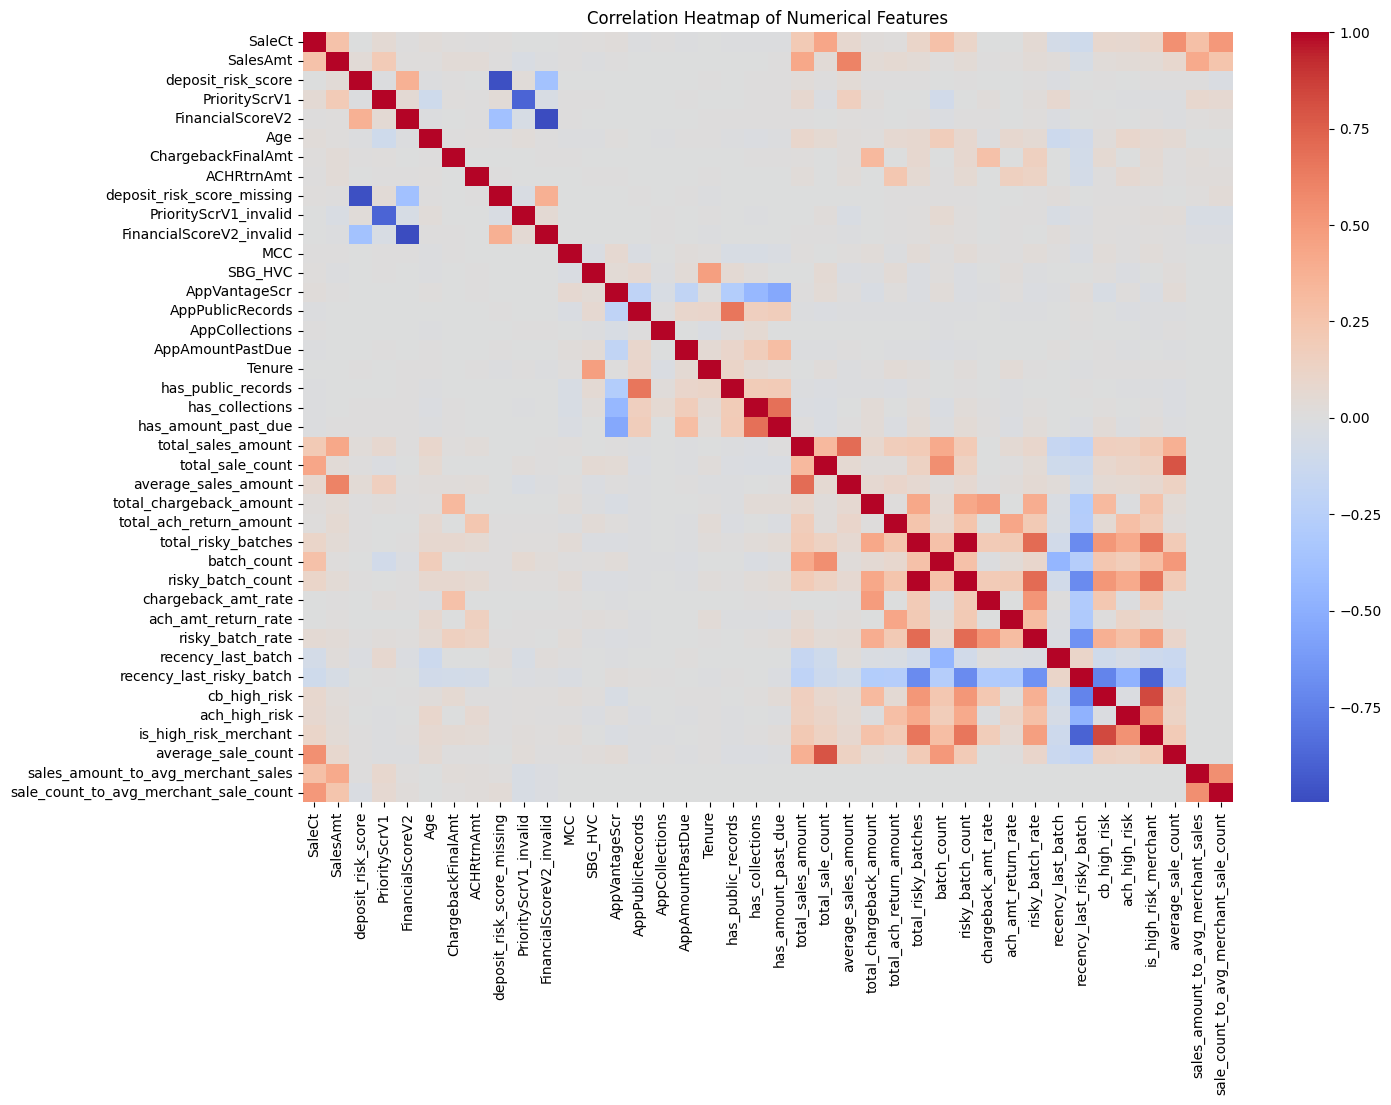

In [146]:
# Select numerical columns from the final_df
# Exclude identifier columns, the target variable, and explicitly exclude categorical/bucket columns
numerical_cols = final_df.select_dtypes(include=np.number).columns.tolist()

# Identify categorical and bucket columns to exclude from correlation calculation
categorical_cols_to_exclude = final_df.select_dtypes(include=['object', 'category']).columns.tolist()
# Also exclude date columns and identifiers
other_cols_to_exclude = ['SimuID', 'is_risky', 'is_chargeback', 'is_ach_return', 'Batch_Clear_Date', 'AccountOpenDate', 'MCCDescription','batch_day_of_week']

# Combine all columns to exclude
all_cols_to_exclude = list(set(categorical_cols_to_exclude + other_cols_to_exclude))

# Filter numerical columns to exclude those in the combined exclude list
numerical_cols_for_heatmap = [col for col in numerical_cols if col not in all_cols_to_exclude]

# Calculate the correlation matrix using only the selected numerical columns
correlation_matrix = final_df[numerical_cols_for_heatmap].corr()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## 7.4 Feature transformation

In [145]:
final_df.columns

Index(['SimuID', 'PaymentChannel', 'SaleCt', 'SalesAmt', 'deposit_risk_score',
       'PriorityScrV1', 'FinancialScoreV2', 'Age', 'ChargebackFinalAmt',
       'ACHRtrnAmt', 'Batch_Clear_Date', 'is_risky',
       'deposit_risk_score_missing', 'PriorityScrV1_invalid',
       'FinancialScoreV2_invalid', 'is_chargeback', 'is_ach_return', 'MCC',
       'MCCDescription', 'Product', 'SBG_HVC', 'AppVantageScr',
       'AppPublicRecords', 'AppCollections', 'AppAmountPastDue',
       'AccountOpenDate', 'Tenure', 'VantageScoreBucket', 'SalesAmtBucket',
       'SalesCtBucket', 'TenureBucket', 'has_public_records',
       'has_collections', 'has_amount_past_due', 'AppCollections_bucket',
       'AppAmountPastDue_bucket', 'total_sales_amount', 'total_sale_count',
       'average_sales_amount', 'total_chargeback_amount',
       'total_ach_return_amount', 'total_risky_batches', 'batch_count',
       'risky_batch_count', 'chargeback_amt_rate', 'ach_amt_return_rate',
       'risky_batch_rate', 'latest_b

In [161]:
# Columns to exclude
cols_to_drop = [
    'SimuID', 'Batch_Clear_Date', 'AccountOpenDate', 'MCCDescription', 'Tenure',
    'cb_high_risk', 'ach_high_risk','is_risky','SalesAmt', 'SaleCt',
    'average_sale_count', 'total_risky_batches',  'VantageScoreBucket', 'SalesAmtBucket',
       'SalesCtBucket', 'TenureBucket',
    'latest_batch_clear_date', 'last_risky_batch_date', 'deposit_risk_score_missing', 'PriorityScrV1_invalid',
       'FinancialScoreV2_invalid','has_public_records',
       'has_collections', 'has_amount_past_due', 'AppCollections_bucket',
       'AppAmountPastDue_bucket', 'total_sales_amount', 'total_sale_count',
       'average_sales_amount', 'total_chargeback_amount',
       'total_ach_return_amount', 'total_risky_batches', 'batch_count', 'cb_high_risk',
       'ach_high_risk','average_sale_count', 'risky_batch_rate', 'ChargebackFinalAmt', 'ACHRtrnAmt'
]

In [162]:
# Chargeback Model
chargeback_df = final_df[final_df['PaymentChannel'] == 'Credit_Card'].drop(columns=cols_to_drop + ['is_ach_return'] )

# ACH Model
ach_df = final_df[final_df['PaymentChannel'] == 'ACH'].drop(columns=cols_to_drop + ['is_chargeback'] )

In [163]:
chargeback_df.shape

(91575, 22)

In [164]:
ach_df.shape

(28891, 22)

In [165]:
ach_df.head()

,PaymentChannel,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,is_ach_return,MCC,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,recency_last_batch,recency_last_risky_batch,is_high_risk_merchant,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,batch_day_of_week
2,ACH,0.000000,76.0,2.3248,6,0,5996,QBMS for QBO,1,920.0,0.0,0.0,0.0,0,0.0,0.0,1,9999.0,0,0.430125,0.711111,Monday
6,ACH,79.539276,133.0,1.6489,432,0,1731,QBMS for QBO,0,809.0,0.0,0.0,0.0,0,0.0,0.0,4,9999.0,0,1.769839,0.750000,Tuesday
17,ACH,11.345259,2.0,-999.0000,692,0,8299,QBMS for QBO,1,588.0,1.0,0.0,0.0,0,0.0,0.0,4,9999.0,0,1.355988,1.695652,Friday
20,ACH,0.405097,32.0,0.7281,534,0,5099,QBMS for QBO,0,884.0,0.0,0.0,0.0,0,0.0,0.0,5,9999.0,0,0.157785,0.297297,Tuesday
21,ACH,2.195992,3.0,1.3896,1087,0,8999,QBMS for QBO,0,851.0,0.0,0.0,0.0,0,0.0,0.0,4,9999.0,0,0.465403,1.294118,Thursday


In [166]:
print("Chargeback distribution:\n", chargeback_df['is_chargeback'].value_counts(normalize=True))
print("ACH return distribution:\n", ach_df['is_ach_return'].value_counts(normalize=True))

Chargeback distribution:
 is_chargeback
0    0.996244
1    0.003756
Name: proportion, dtype: float64
ACH return distribution:
 is_ach_return
0    0.993147
1    0.006853
Name: proportion, dtype: float64


In [167]:
# Drop targets to isolate features
cb_features = chargeback_df.drop(columns=['is_chargeback','PaymentChannel'])
ach_features = ach_df.drop(columns=['is_ach_return','PaymentChannel'])

# Targets
cb_target = chargeback_df['is_chargeback']
ach_target = ach_df['is_ach_return']

# Categorical and numerical columns
cat_cols_cb = cb_features.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols_cb = cb_features.select_dtypes(include='number').columns.tolist()

cat_cols_ach = ach_features.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols_ach = ach_features.select_dtypes(include='number').columns.tolist()

In [168]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Encoder and Scaler
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

In [169]:
cb_features = cb_features.reset_index(drop=True)
cb_target = cb_target.reset_index(drop=True)

# Fit and transform chargeback features
cb_ohe_df = pd.DataFrame(
    ohe.fit_transform(cb_features[cat_cols_cb]),
    columns=ohe.get_feature_names_out(cat_cols_cb)
)

cb_scaled_df = pd.DataFrame(
    scaler.fit_transform(cb_features[num_cols_cb]),
    columns=num_cols_cb
)

# Combine and assign target
cb_transformed = pd.concat([cb_ohe_df, cb_scaled_df], axis=1)
cb_transformed['is_chargeback'] = cb_target

In [170]:
ach_features = ach_features.reset_index(drop=True)
ach_target = ach_target.reset_index(drop=True)

# One-hot encode categorical columns
ach_ohe_df = pd.DataFrame(
    ohe.fit_transform(ach_features[cat_cols_ach]),
    columns=ohe.get_feature_names_out(cat_cols_ach)
)

# Scale numerical columns
ach_scaled_df = pd.DataFrame(
    scaler.fit_transform(ach_features[num_cols_ach]),
    columns=num_cols_ach
)

# Combine transformed features
ach_transformed = pd.concat([ach_ohe_df, ach_scaled_df], axis=1)
ach_transformed['is_ach_return'] = ach_target

In [171]:
ach_transformed.head()

,Product_GoPayment Free,Product_QBMS for QBO,batch_day_of_week_Monday,batch_day_of_week_Saturday,batch_day_of_week_Sunday,batch_day_of_week_Thursday,batch_day_of_week_Tuesday,batch_day_of_week_Wednesday,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,MCC,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,recency_last_batch,recency_last_risky_batch,is_high_risk_merchant,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,is_ach_return
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.379778,0.290549,0.259254,-1.430216,-0.063122,2.085235,1.123349,-0.222336,-0.314698,-0.180873,-0.246819,-0.046988,-0.125289,-0.530475,0.306431,-0.273229,-0.542398,-0.375473,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.583537,0.501535,0.256537,-0.333310,-1.755735,-0.479562,0.208925,-0.222336,-0.314698,-0.180873,-0.246819,-0.046988,-0.125289,-0.107768,0.306431,-0.273229,0.741661,-0.311137,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408842,0.016638,-3.766021,0.336163,0.850849,2.085235,-1.611684,0.989873,-0.314698,-0.180873,-0.246819,-0.046988,-0.125289,-0.107768,0.306431,-0.273229,0.345002,1.253288,0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.380816,0.127683,0.252836,-0.070671,-0.419107,-0.479562,0.826779,-0.222336,-0.314698,-0.180873,-0.246819,-0.046988,-0.125289,0.033135,0.306431,-0.273229,-0.803424,-1.060060,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.385404,0.020340,0.255495,1.353247,1.128652,-0.479562,0.554923,-0.222336,-0.314698,-0.180873,-0.246819,-0.046988,-0.125289,-0.107768,0.306431,-0.273229,-0.508585,0.589016,0


In [172]:
ach_transformed.shape

(28891, 27)

In [173]:
cb_transformed.head()

,Product_GoPayment Free,Product_QBMS for QBO,batch_day_of_week_Monday,batch_day_of_week_Saturday,batch_day_of_week_Sunday,batch_day_of_week_Thursday,batch_day_of_week_Tuesday,batch_day_of_week_Wednesday,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,MCC,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,recency_last_batch,recency_last_risky_batch,is_high_risk_merchant,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,is_chargeback
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.272616,0.842583,0.309940,-1.480425,0.883755,-0.469258,0.039110,-0.229706,-0.033286,-0.147631,-0.185663,-0.091418,-0.073001,1.912693,0.278397,-0.247183,-0.625468,-0.027742,0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.432081,-2.623596,0.586029,1.280810,0.480754,-0.469258,-1.575596,-0.229706,-0.033286,-0.146770,5.294468,2.078218,-0.073001,-0.565951,-3.591259,4.045587,-0.385999,-0.812471,0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.442193,0.194778,0.692157,0.164363,0.475546,-0.469258,0.637149,-0.229706,-0.033286,-0.147631,1.184370,0.179084,-0.073001,-0.565951,-3.587381,4.045587,-0.494101,-0.521000,0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.169399,0.200386,-3.412701,-0.751267,1.097273,-0.469258,1.534208,-0.229706,-0.033286,-0.147631,-0.185663,-0.091418,-0.073001,-0.400708,0.278397,-0.247183,-0.192970,-0.382739,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433828,0.214408,-3.412701,1.701570,0.480754,-0.469258,-1.507248,-0.229706,-0.033286,-0.147631,-0.185663,-0.091418,-0.073001,-0.565951,0.278397,-0.247183,0.542539,1.140600,0


In [174]:
cb_transformed.shape

(91575, 27)

# **8. Modelling**

In [175]:
from sklearn.model_selection import train_test_split

### CHARGEBACK MODEL ###

# Separate features and target
X_cb = cb_transformed.drop(columns=['is_chargeback'])
y_cb = cb_transformed['is_chargeback']

# First split: train vs temp (60/40)
X_cb_train, X_cb_temp, y_cb_train, y_cb_temp = train_test_split(
    X_cb, y_cb, test_size=0.4, stratify=y_cb, random_state=42
)

# Second split: temp → val/test (50/50 of temp = 20% each)
X_cb_val, X_cb_holdout, y_cb_val, y_cb_holdout = train_test_split(
    X_cb_temp, y_cb_temp, test_size=0.5, stratify=y_cb_temp, random_state=42
)

In [176]:
print("Train:", X_cb_train.shape, y_cb_train.shape)
print("Validation:", X_cb_val.shape, y_cb_val.shape)
print("Holdout:", X_cb_holdout.shape, y_cb_holdout.shape)

Train: (54945, 26) (54945,)
Validation: (18315, 26) (18315,)
Holdout: (18315, 26) (18315,)


In [177]:
### ACH RETURN MODEL ###

X_ach = ach_transformed.drop(columns=['is_ach_return'])
y_ach = ach_transformed['is_ach_return']

# First split: train vs temp (60/40)
X_ach_train, X_ach_temp, y_ach_train, y_ach_temp = train_test_split(
    X_ach, y_ach, test_size=0.4, stratify=y_ach, random_state=42
)

# Second split: temp → val/test (50/50 of temp = 20% each)
X_ach_val, X_ach_holdout, y_ach_val, y_ach_holdout = train_test_split(
    X_ach_temp, y_ach_temp, test_size=0.5, stratify=y_ach_temp, random_state=42
)

In [178]:
print("Train:", X_ach_train.shape, y_ach_train.shape)
print("Validation:", X_ach_val.shape, y_ach_val.shape)
print("Holdout:", X_ach_holdout.shape, y_ach_holdout.shape)

Train: (17334, 26) (17334,)
Validation: (5778, 26) (5778,)
Holdout: (5779, 26) (5779,)


## 8.1 Logistic Regression

**ACH prediction**

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the Logistic Regression model
# We can use class_weight='balanced' to help address the class imbalance
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_ach_train, y_ach_train)

# Make predictions on the val set
y_val_ach_pred = logistic_model.predict(X_ach_val)
y_val_ach_proba = logistic_model.predict_proba(X_ach_val)[:, 1] # Get probabilities for the positive class

In [180]:
# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation (ACH):")

# Evaluate at default threshold (0.5)
print("Validation AUC:", roc_auc_score(y_ach_val, y_val_ach_proba))
print("Validation Confusion Matrix:\n", confusion_matrix(y_ach_val, y_val_ach_pred))
print("Validation Report:\n", classification_report(y_ach_val, y_val_ach_pred))

Logistic Regression Model Evaluation (ACH):
Validation AUC: 0.9831204399944599
Validation Confusion Matrix:
 [[5367  372]
 [   2   37]]
Validation Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      5739
           1       0.09      0.95      0.17        39

    accuracy                           0.94      5778
   macro avg       0.55      0.94      0.57      5778
weighted avg       0.99      0.94      0.96      5778



In [181]:
# Predict probabilities
y_ach_holdout_proba = logistic_model.predict_proba(X_ach_holdout)[:, 1]

# Predict class labels using default threshold = 0.5
y_ach_holdout_pred = (y_ach_holdout_proba >= 0.5).astype(int)

In [182]:
# Confusion matrix
print("Holdout Confusion Matrix:\n", confusion_matrix(y_ach_holdout, y_ach_holdout_pred))

# Classification report
print("\nHoldout Classification Report:")
print(classification_report(y_ach_holdout, y_ach_holdout_pred))

# ROC AUC Score
print("Holdout ROC AUC Score:", roc_auc_score(y_ach_holdout, y_ach_holdout_proba))

Holdout Confusion Matrix:
 [[5415  324]
 [   0   40]]

Holdout Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5739
           1       0.11      1.00      0.20        40

    accuracy                           0.94      5779
   macro avg       0.55      0.97      0.58      5779
weighted avg       0.99      0.94      0.97      5779

Holdout ROC AUC Score: 0.9903946680606378


**Chargeback prediction**

In [183]:
# Initialize and train the Logistic Regression model
# We can use class_weight='balanced' to help address the class imbalance
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_cb_train, y_cb_train)

# Make predictions on the val set
y_val_cb_pred = logistic_model.predict(X_cb_val)
y_val_cb_proba = logistic_model.predict_proba(X_cb_val)[:, 1] # Get probabilities for the positive class

In [184]:
# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation (Chargeback):")

# Evaluate at default threshold (0.5)
print("Validation AUC:", roc_auc_score(y_cb_val, y_val_cb_proba))
print("Validation Confusion Matrix:\n", confusion_matrix(y_cb_val, y_val_cb_pred))
print("Validation Report:\n", classification_report(y_cb_val, y_val_cb_pred))

Logistic Regression Model Evaluation (Chargeback):
Validation AUC: 0.9826581009615766
Validation Confusion Matrix:
 [[17135  1111]
 [    1    68]]
Validation Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     18246
           1       0.06      0.99      0.11        69

    accuracy                           0.94     18315
   macro avg       0.53      0.96      0.54     18315
weighted avg       1.00      0.94      0.97     18315



In [185]:
# Predict probabilities
y_cb_holdout_proba = logistic_model.predict_proba(X_cb_holdout)[:, 1]

# Predict class labels using default threshold = 0.5
y_cb_holdout_pred = (y_cb_holdout_proba >= 0.5).astype(int)

In [186]:
# Confusion matrix
print("Holdout Confusion Matrix:\n", confusion_matrix(y_cb_holdout, y_cb_holdout_pred))

# Classification report
print("\nHoldout Classification Report:")
print(classification_report(y_cb_holdout, y_cb_holdout_pred))

# ROC AUC Score
print("Holdout ROC AUC Score:", roc_auc_score(y_cb_holdout, y_cb_holdout_proba))

Holdout Confusion Matrix:
 [[17204  1042]
 [    0    69]]

Holdout Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     18246
           1       0.06      1.00      0.12        69

    accuracy                           0.94     18315
   macro avg       0.53      0.97      0.54     18315
weighted avg       1.00      0.94      0.97     18315

Holdout ROC AUC Score: 0.9817923166006605


In [187]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

# Define the parameter distribution for Randomized Search for Logistic Regression
param_dist_lr = {
    'C': uniform(0.01, 100),  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'], # Solvers
    'class_weight': ['balanced', None] # Class weight options
}

# Initialize the Logistic Regression model with fixed random state
lr_model = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for Logistic Regression: ", random_search_lr.best_params_)
print("Best ROC AUC score for Logistic Regression: ", random_search_lr.best_score_)

# Get the best Logistic Regression model
best_lr_model = random_search_lr.best_estimator_
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform\nfrom sklearn.linear_model import LogisticRegression\n\n# Define the parameter distribution for Randomized Search for Logistic Regression\nparam_dist_lr = {\n    \'C\': uniform(0.01, 100),  # Inverse of regularization strength\n    \'solver\': [\'liblinear\', \'lbfgs\', \'sag\', \'saga\'], # Solvers\n    \'class_weight\': [\'balanced\', None] # Class weight options\n}\n\n# Initialize the Logistic Regression model with fixed random state\nlr_model = LogisticRegression(random_state=42)\n\n# Initialize RandomizedSearchCV\n# We\'ll use ROC AUC as the scoring metric for tuning\nrandom_search_lr = RandomizedSearchCV(\n    estimator=lr_model,\n    param_distributions=param_dist_lr,\n    n_iter=50,  # Number of parameter settings that are sampled\n    scoring=\'roc_auc\', # Optimize for ROC AUC\n    cv=3,       # 3-fold cross-validation\n    verbose=2,\n    random_state=42,\n    n_jobs=-1   # Use all ava

In [188]:
"""
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_lr = best_lr_model.predict(X_test)
y_pred_proba_best_lr = best_lr_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best Logistic Regression model
print("Best Logistic Regression Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lr))

# Calculate ROC AUC score
roc_auc_best_lr = roc_auc_score(y_test, y_pred_proba_best_lr)
print(f"\nROC AUC Score: {roc_auc_best_lr}")
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\n\n# Make predictions on the test set using the best model\ny_pred_best_lr = best_lr_model.predict(X_test)\ny_pred_proba_best_lr = best_lr_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class\n\n# Evaluate the best Logistic Regression model\nprint("Best Logistic Regression Model Evaluation (on Test Set):")\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_best_lr))\n\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_best_lr))\n\n# Calculate ROC AUC score\nroc_auc_best_lr = roc_auc_score(y_test, y_pred_proba_best_lr)\nprint(f"\nROC AUC Score: {roc_auc_best_lr}")\n'

## 8.2 LightGBM

In [189]:
# %pip install lightgbm

In [190]:
import lightgbm as lgb

**ACH Prediction**

In [191]:
# Handle class imbalance
ach_scale_pos_weight = len(y_ach_train[y_ach_train == 0]) / len(y_ach_train[y_ach_train == 1])

# Model
ach_model = lgb.LGBMClassifier(
    random_state=42,
    scale_pos_weight=ach_scale_pos_weight,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=-1
)

# Train
ach_model.fit(X_ach_train, y_ach_train)

# Predict
y_ach_val_pred = ach_model.predict(X_ach_val)
y_ach_val_proba = ach_model.predict_proba(X_ach_val)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 17215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 17334, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006865 -> initscore=-4.974413
[LightGBM] [Info] Start training from score -4.974413


In [192]:
print("LightGBM Model Evaluation (ACH):")

print("ROC AUC:", roc_auc_score(y_ach_val, y_ach_val_proba))
print("Confusion Matrix:\n", confusion_matrix(y_ach_val, y_ach_val_pred))
print("Classification Report:\n", classification_report(y_ach_val, y_ach_val_pred))

LightGBM Model Evaluation (ACH):
ROC AUC: 0.8996564218728358
Confusion Matrix:
 [[5663   76]
 [  24   15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      5739
           1       0.16      0.38      0.23        39

    accuracy                           0.98      5778
   macro avg       0.58      0.69      0.61      5778
weighted avg       0.99      0.98      0.99      5778



In [193]:
# Predict probabilities and class labels for the ACH holdout set
y_ach_holdout_proba = ach_model.predict_proba(X_ach_holdout)[:, 1]
y_ach_holdout_pred = (y_ach_holdout_proba >= 0.5).astype(int)

# Evaluate performance
print("Holdout Evaluation (ACH):")
print("ROC AUC:", roc_auc_score(y_ach_holdout, y_ach_holdout_proba))
print("Confusion Matrix:\n", confusion_matrix(y_ach_holdout, y_ach_holdout_pred))
print("Classification Report:\n", classification_report(y_ach_holdout, y_ach_holdout_pred))

Holdout Evaluation (ACH):
ROC AUC: 0.9604504269036418
Confusion Matrix:
 [[5667   72]
 [  24   16]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      5739
           1       0.18      0.40      0.25        40

    accuracy                           0.98      5779
   macro avg       0.59      0.69      0.62      5779
weighted avg       0.99      0.98      0.99      5779



**Chargeback Prediction**

In [194]:
# Handle class imbalance
cb_scale_pos_weight = len(y_cb_train[y_cb_train == 0]) / len(y_cb_train[y_cb_train == 1])

# Model
cb_model = lgb.LGBMClassifier(
    random_state=42,
    scale_pos_weight=cb_scale_pos_weight,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=-1
)

# Train
cb_model.fit(X_cb_train, y_cb_train)

# Predict
y_cb_val_pred = cb_model.predict(X_cb_val)
y_cb_val_proba = cb_model.predict_proba(X_cb_val)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 206, number of negative: 54739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 54945, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003749 -> initscore=-5.582456
[LightGBM] [Info] Start training from score -5.582456


In [195]:
# Eval
print("AUC:", roc_auc_score(y_cb_val, y_cb_val_proba))
print("Confusion Matrix:\n", confusion_matrix(y_cb_val, y_cb_val_pred))
print("Classification Report:\n", classification_report(y_cb_val, y_cb_val_pred))

AUC: 0.7416316778583195
Confusion Matrix:
 [[18081   165]
 [   43    26]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     18246
           1       0.14      0.38      0.20        69

    accuracy                           0.99     18315
   macro avg       0.57      0.68      0.60     18315
weighted avg       0.99      0.99      0.99     18315



In [196]:
# Predict probabilities and class labels for the CB holdout set
y_cb_holdout_proba = cb_model.predict_proba(X_cb_holdout)[:, 1]
y_cb_holdout_pred = (y_cb_holdout_proba >= 0.5).astype(int)

In [197]:
# Evaluate performance

print("ROC AUC:", roc_auc_score(y_cb_holdout, y_cb_holdout_proba))
print("Confusion Matrix:\n", confusion_matrix(y_cb_holdout, y_cb_holdout_pred))
print("Classification Report:\n", classification_report(y_cb_holdout, y_cb_holdout_pred))

ROC AUC: 0.6785183808402716
Confusion Matrix:
 [[18109   137]
 [   49    20]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     18246
           1       0.13      0.29      0.18        69

    accuracy                           0.99     18315
   macro avg       0.56      0.64      0.59     18315
weighted avg       0.99      0.99      0.99     18315



In [198]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(50, 500),       # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),    # Step size shrinkage
    'num_leaves': randint(20, 150),         # Maximum number of leaves in one tree
    'max_depth': randint(-1, 20),           # Maximum tree depth (-1 means no limit)
    'min_child_samples': randint(5, 50),    # Minimum number of data needed in a child
    'subsample': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners
    'reg_alpha': uniform(0, 1),             # L1 regularization
    'reg_lambda': uniform(0, 1),            # L2 regularization
    'scale_pos_weight': [scale_pos_weight_value] # Use the calculated scale_pos_weight
}

# Initialize the LightGBM model with fixed random state
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best ROC AUC score: ", random_search.best_score_)

# Get the best model
best_lgbm_model = random_search.best_estimator_
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\nimport lightgbm as lgb\n\n# Define the parameter distribution for Randomized Search\nparam_dist = {\n    \'n_estimators\': randint(50, 500),       # Number of boosting rounds\n    \'learning_rate\': uniform(0.01, 0.1),    # Step size shrinkage\n    \'num_leaves\': randint(20, 150),         # Maximum number of leaves in one tree\n    \'max_depth\': randint(-1, 20),           # Maximum tree depth (-1 means no limit)\n    \'min_child_samples\': randint(5, 50),    # Minimum number of data needed in a child\n    \'subsample\': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners\n    \'colsample_bytree\': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners\n    \'reg_alpha\': uniform(0, 1),             # L1 regularization\n    \'reg_lambda\': uniform(0, 1),            # L2 regularization\n    \'scale_pos_weight\':

In [199]:
"""
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_lgbm = best_lgbm_model.predict(X_test)
y_pred_proba_best_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best LightGBM model
print("Best LightGBM Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lgbm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lgbm))

# Calculate ROC AUC score
roc_auc_best_lgbm = roc_auc_score(y_test, y_pred_proba_best_lgbm)
print(f"\nROC AUC Score: {roc_auc_best_lgbm}")
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\n\n# Make predictions on the test set using the best model\ny_pred_best_lgbm = best_lgbm_model.predict(X_test)\ny_pred_proba_best_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class\n\n# Evaluate the best LightGBM model\nprint("Best LightGBM Model Evaluation (on Test Set):")\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_best_lgbm))\n\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_best_lgbm))\n\n# Calculate ROC AUC score\nroc_auc_best_lgbm = roc_auc_score(y_test, y_pred_proba_best_lgbm)\nprint(f"\nROC AUC Score: {roc_auc_best_lgbm}")\n'

## 8.3 XGB

In [200]:
#%pip install xgboost

In [201]:
from xgboost import XGBClassifier

**ACH**

In [202]:
# Initialize XGBoost model for ACH return detection
xgb_ach_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=ach_scale_pos_weight,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit model on training data
xgb_ach_model.fit(X_ach_train, y_ach_train)

# Evaluate on Validation Set
y_ach_val_proba_xgb = xgb_ach_model.predict_proba(X_ach_val)[:, 1]
y_ach_val_pred_xgb = (y_ach_val_proba_xgb >= 0.5).astype(int)

In [203]:
print("ROC AUC:", roc_auc_score(y_ach_val, y_ach_val_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_ach_val, y_ach_val_pred_xgb))
print("Classification Report:\n", classification_report(y_ach_val, y_ach_val_pred_xgb))

ROC AUC: 0.9748906492241569
Confusion Matrix:
 [[5566  173]
 [  16   23]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      5739
           1       0.12      0.59      0.20        39

    accuracy                           0.97      5778
   macro avg       0.56      0.78      0.59      5778
weighted avg       0.99      0.97      0.98      5778



In [204]:
y_ach_holdout_proba_xgb = xgb_ach_model.predict_proba(X_ach_holdout)[:, 1]
y_ach_holdout_pred_xgb = (y_ach_holdout_proba_xgb >= 0.5).astype(int)

In [205]:
print("ROC AUC:", roc_auc_score(y_ach_holdout, y_ach_holdout_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_ach_holdout, y_ach_holdout_pred_xgb))
print("Classification Report:\n", classification_report(y_ach_holdout, y_ach_holdout_pred_xgb))

ROC AUC: 0.9810158564209793
Confusion Matrix:
 [[5588  151]
 [  13   27]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      5739
           1       0.15      0.68      0.25        40

    accuracy                           0.97      5779
   macro avg       0.57      0.82      0.62      5779
weighted avg       0.99      0.97      0.98      5779



**Chargeback**

In [206]:

xgb_cb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=cb_scale_pos_weight,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_cb_model.fit(X_cb_train, y_cb_train)

# Predict
xgb_cb_val_pred = xgb_cb_model.predict(X_cb_val)
xgb_cb_val_proba = xgb_cb_model.predict_proba(X_cb_val)[:, 1]

In [207]:
print("ROC AUC:", roc_auc_score(y_cb_val, xgb_cb_val_proba))
print("Confusion Matrix:\n", confusion_matrix(y_cb_val, xgb_cb_val_pred))
print("Classification Report:\n", classification_report(y_cb_val, xgb_cb_val_pred))

ROC AUC: 0.9816000965865856
Confusion Matrix:
 [[17757   489]
 [   18    51]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     18246
           1       0.09      0.74      0.17        69

    accuracy                           0.97     18315
   macro avg       0.55      0.86      0.58     18315
weighted avg       1.00      0.97      0.98     18315



In [208]:
y_cb_holdout_proba_xgb = xgb_cb_model.predict_proba(X_cb_holdout)[:, 1]
y_cb_holdout_pred_xgb = (y_cb_holdout_proba_xgb >= 0.5).astype(int)

In [209]:
# Evaluate

print("ROC AUC:", roc_auc_score(y_cb_holdout, y_cb_holdout_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_cb_holdout, y_cb_holdout_pred_xgb))
print("Classification Report:\n", classification_report(y_cb_holdout, y_cb_holdout_pred_xgb))

ROC AUC: 0.9817943023446075
Confusion Matrix:
 [[17775   471]
 [   22    47]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     18246
           1       0.09      0.68      0.16        69

    accuracy                           0.97     18315
   macro avg       0.54      0.83      0.57     18315
weighted avg       1.00      0.97      0.98     18315



In [210]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

# Define the parameter distribution for Randomized Search for XGBoost
param_dist_xgb = {
    'n_estimators': randint(50, 500),       # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),    # Step size shrinkage
    'max_depth': randint(3, 10),           # Maximum tree depth
    'min_child_weight': randint(1, 10),    # Minimum sum of instance weight (hessian) needed in a child
    'subsample': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners
    'gamma': uniform(0, 0.5),              # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),             # L1 regularization
    'reg_lambda': uniform(0, 1),            # L2 regularization
    'scale_pos_weight': [scale_pos_weight_value] # Use the calculated scale_pos_weight
}

# Initialize the XGBoost model with fixed random state
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss') # Use logloss or AUC as eval_metric

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search_xgb.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for XGBoost: ", random_search_xgb.best_params_)
print("Best ROC AUC score for XGBoost: ", random_search_xgb.best_score_)

# Get the best XGBoost model
best_xgb_model = random_search_xgb.best_estimator_
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\nimport xgboost as xgb\n\n# Define the parameter distribution for Randomized Search for XGBoost\nparam_dist_xgb = {\n    \'n_estimators\': randint(50, 500),       # Number of boosting rounds\n    \'learning_rate\': uniform(0.01, 0.1),    # Step size shrinkage\n    \'max_depth\': randint(3, 10),           # Maximum tree depth\n    \'min_child_weight\': randint(1, 10),    # Minimum sum of instance weight (hessian) needed in a child\n    \'subsample\': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners\n    \'colsample_bytree\': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners\n    \'gamma\': uniform(0, 0.5),              # Minimum loss reduction required to make a further partition\n    \'reg_alpha\': uniform(0, 1),             # L1 regularization\n    \'reg_lambda\': uniform(0, 1),            # L2 regulari

In [211]:
"""
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best XGBoost model
print("Best XGBoost Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))

# Calculate ROC AUC score
roc_auc_best_xgb = roc_auc_score(y_test, y_pred_proba_best_xgb)
print(f"\nROC AUC Score: {roc_auc_best_xgb}")
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\n\n# Make predictions on the test set using the best model\ny_pred_best_xgb = best_xgb_model.predict(X_test)\ny_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class\n\n# Evaluate the best XGBoost model\nprint("Best XGBoost Model Evaluation (on Test Set):")\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_best_xgb))\n\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_best_xgb))\n\n# Calculate ROC AUC score\nroc_auc_best_xgb = roc_auc_score(y_test, y_pred_proba_best_xgb)\nprint(f"\nROC AUC Score: {roc_auc_best_xgb}")\n'

# **9. Feature Importances**

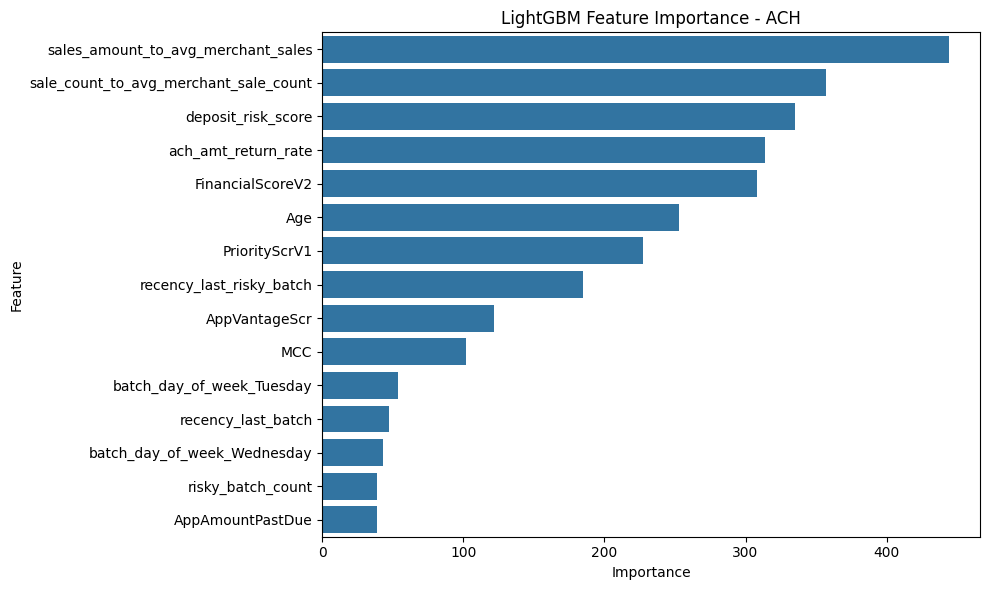

In [212]:
def plot_lgb_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# LightGBM - ACH
plot_lgb_feature_importance(ach_model, X_ach_train.columns, "LightGBM Feature Importance - ACH")

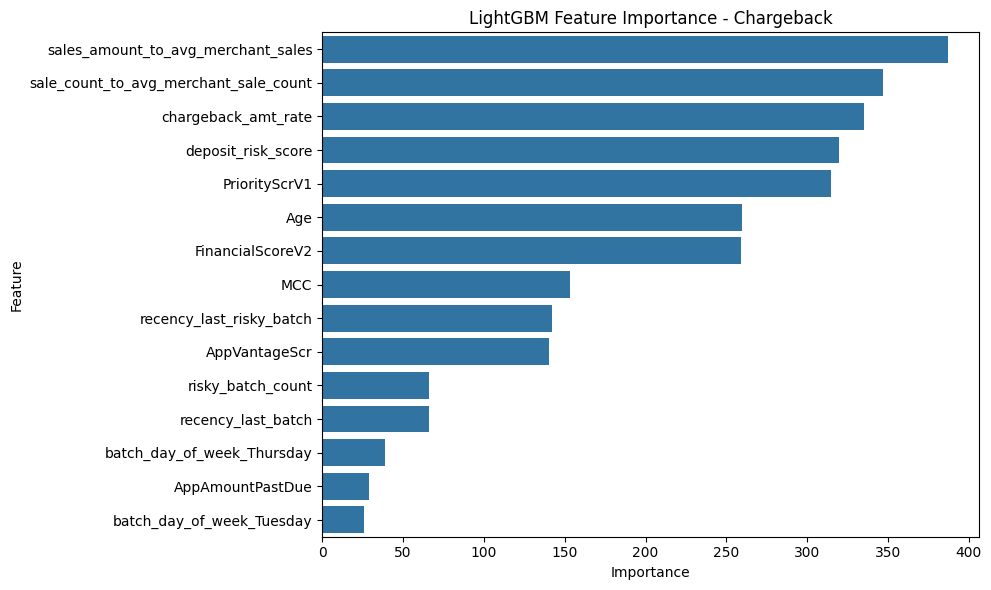

In [213]:
# LightGBM - Chargeback
plot_lgb_feature_importance(cb_model, X_cb_train.columns, "LightGBM Feature Importance - Chargeback")

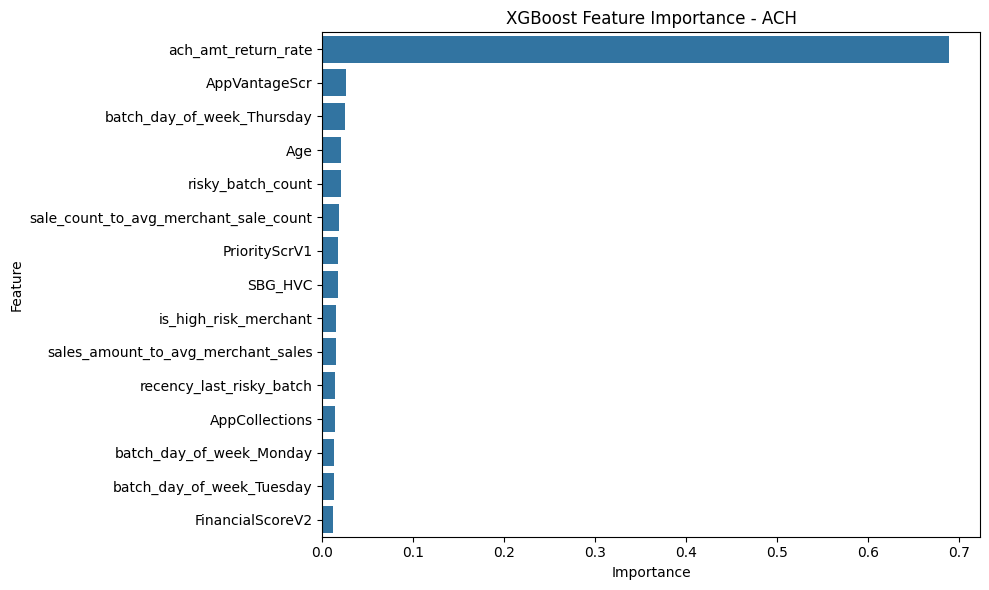

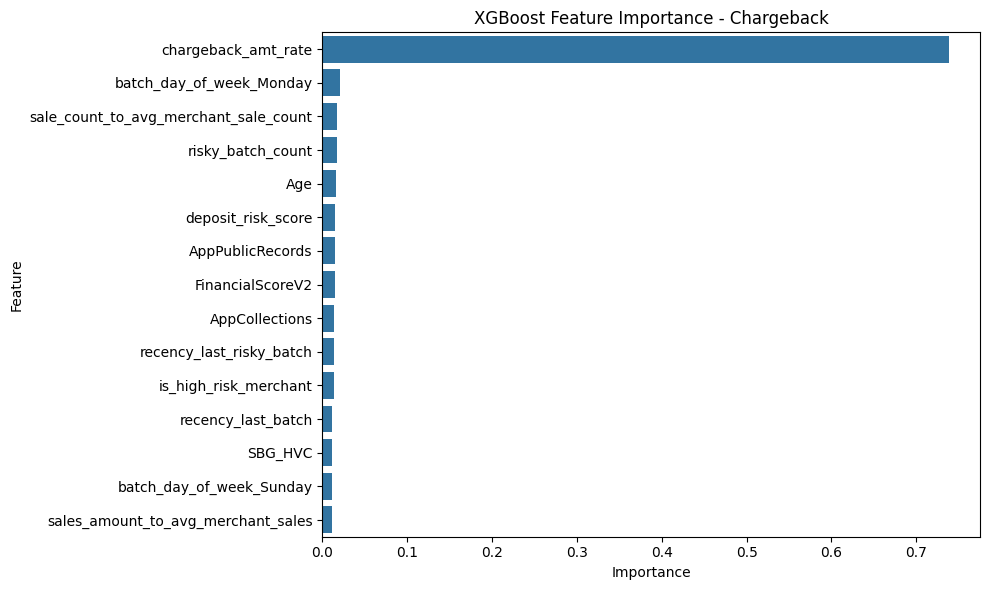

In [214]:
def plot_xgb_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# XGBoost - ACH
plot_xgb_feature_importance(xgb_ach_model, X_ach_train.columns, "XGBoost Feature Importance - ACH")

# XGBoost - Chargeback
plot_xgb_feature_importance(xgb_cb_model, X_cb_train.columns, "XGBoost Feature Importance - Chargeback")

**Insights:**

**Chargeback Risk**
*   Unusually high sales amount vs avg merchant sales is the strongest indicator of fraud.
*   Younger accounts with high variance in sale counts show elevated chargeback risk.
*   Risk scores (FinancialScoreV2, PriorityScrV1, AppVantageScr) and deposit_risk_score rank high, signaling strong historical risk correlation.

**ACH Risk**


*   sales_amount_to_avg_merchant_sales and deposit_risk_score are top predictors—large transaction spikes vs merchant norms are red flags.
*   Accounts with frequent risky batches, recent activity in flagged batches, or younger age are at higher risk.

# **10. Risk Insights**

1. Merchants with 'Poor' (<550) Vantage Scores show a considerably higher chargeback rate compared to those with 'Fair', 'Good', or 'Excellent' scores. The trend is less clear for ACH returns across Vantage Score buckets.
2. Salesamt - for chargeback 2500+ sales have high return rates, ach 5000+ sales have high return rates
3. Salect - for chargeback 5+ sales have high return rates, ach 10+ sales have high return rates
4. Unknown Tenure + Excellent Credit - merchants have high chargeback and ach return rates despite good scores. Might be possibly synthetic or incomplete profiles
5. Merchants with a history of collections ('has_collections' = 1) have a higher chargeback rate compared to those without collections
6. Merchants with any amount past due ('has_amount_past_due' = 1) also show a higher chargeback rate compared to those without.
7. Batches where the deposit_risk_score was missing showed a slightly higher proportion of risky batches.
8. Certain Merchant categories have very high chargeback and return rates

# **11. Policies**

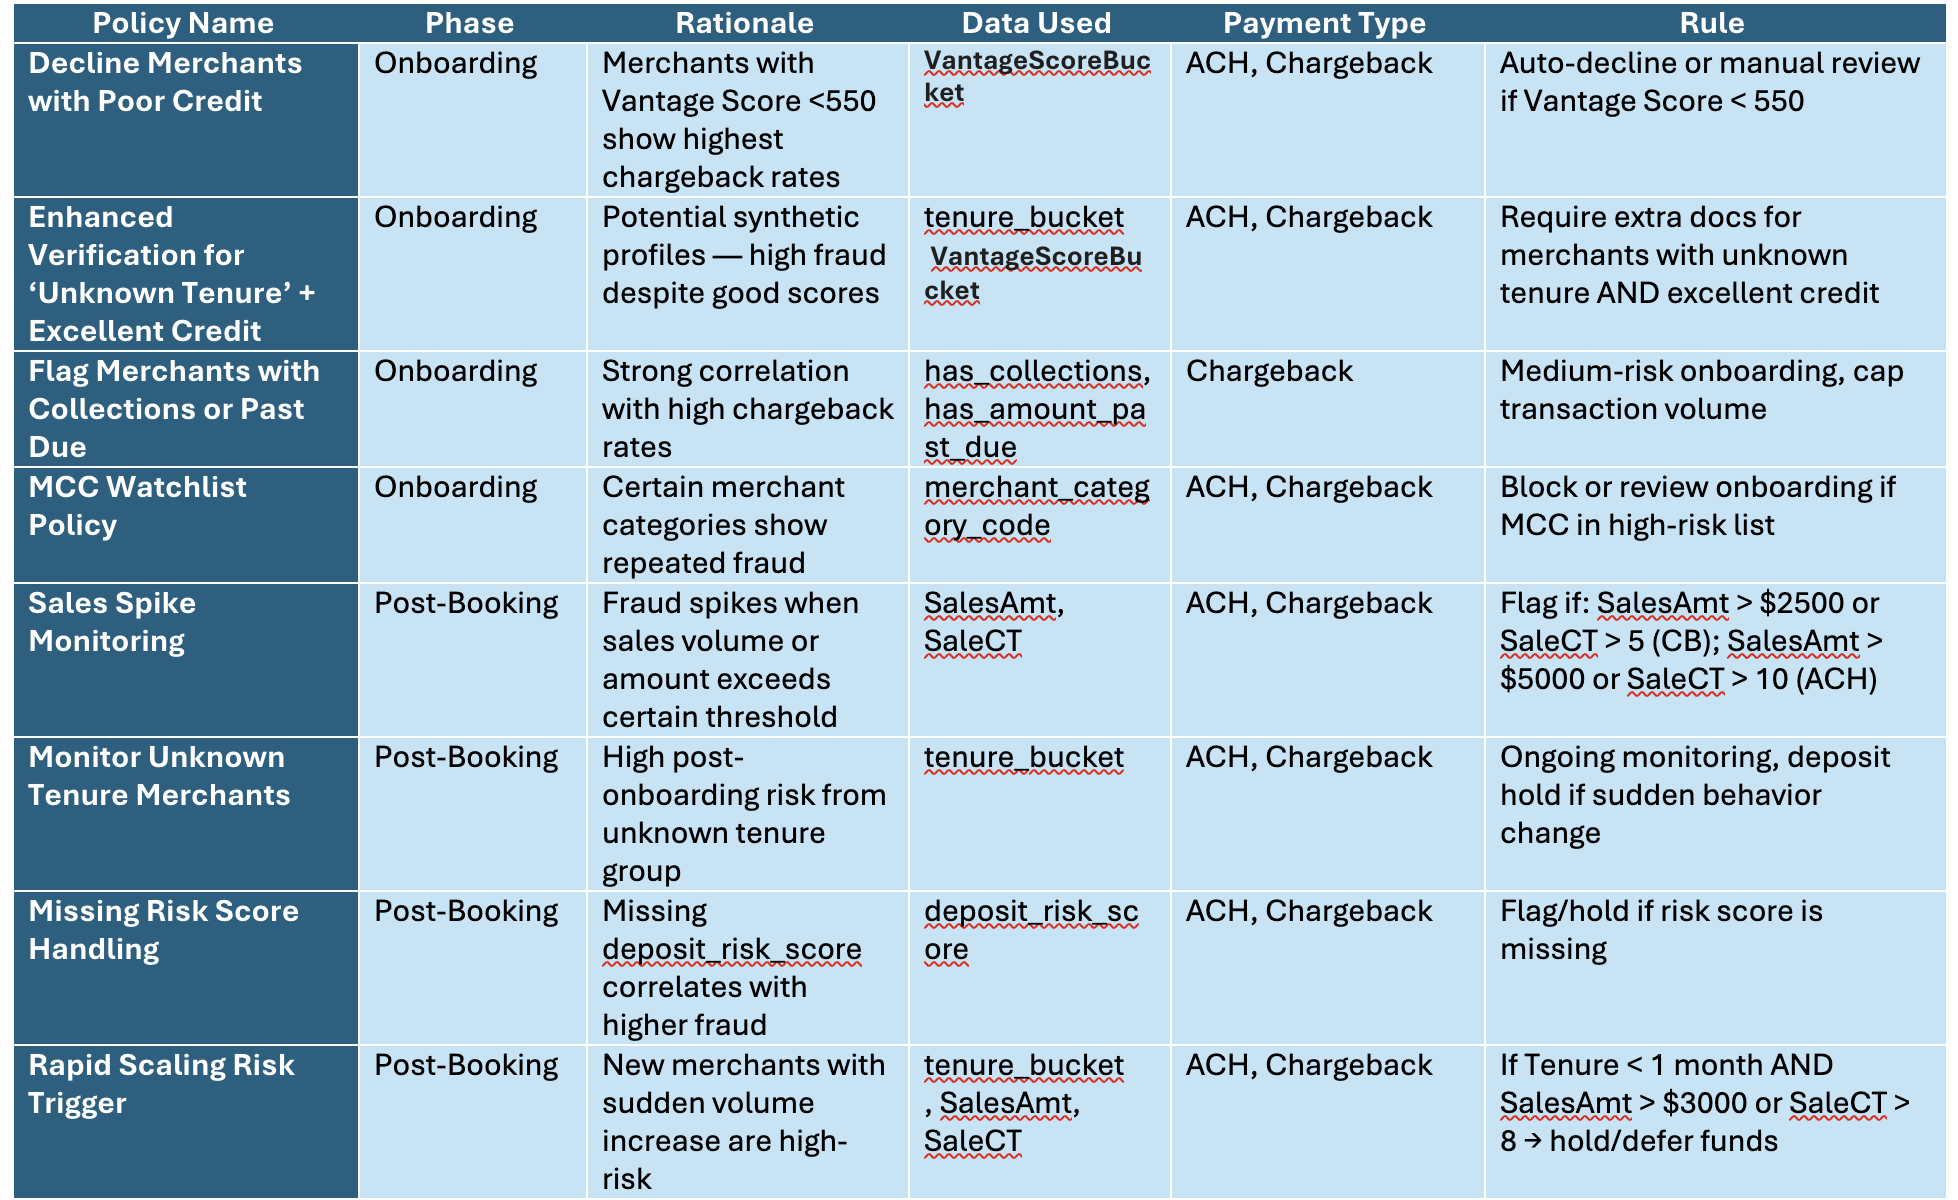

# **12. Rules**

In [215]:
final_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket,has_public_records,has_collections,has_amount_past_due,AppCollections_bucket,AppAmountPastDue_bucket,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,cb_high_risk,ach_high_risk,is_high_risk_merchant,average_sale_count,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,batch_day_of_week
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,2017-03-30,442,Good,mid_sales,0-2_sales,New,0,0,0,Low_collections,Low_pastdue,3890.66,4.0,1945.330000,0.0,0.0,0,2,0,0.000000,0.0,0.000000,2018-06-15,15,NaT,9999.0,0,0,0,2.000000,0.359147,1.000000,Friday
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,2017-08-14,278,Fair,mid_sales,0-2_sales,Tenured,0,0,1,Low_collections,Low_pastdue,56199.67,76.0,1652.931471,3000.0,0.0,4,34,4,0.053381,0.0,0.117647,2018-06-30,0,2018-06-09,21.0,1,0,1,2.235294,0.604986,0.447368,Saturday
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,2018-06-11,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,2016-04-25,777,Excellent,mid_sales,0-2_sales,New,0,0,0,Low_collections,Low_pastdue,23137.46,45.0,1446.091250,0.0,0.0,0,16,0,0.000000,0.0,0.000000,2018-06-29,1,NaT,9999.0,0,0,0,2.812500,0.430125,0.711111,Monday
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,2017-09-01,283,Excellent,low_sales,0-2_sales,Tenured,0,0,0,Low_collections,Low_pastdue,31375.94,95.0,1012.127097,200.0,0.0,1,31,1,0.006655,0.0,0.032258,2018-06-30,0,2018-05-30,31.0,1,0,1,3.064516,0.494009,0.652632,Monday
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,2017-08-16,286,Excellent,mid_sales,0-2_sales,Tenured,0,0,0,Low_collections,Low_pastdue,12700.00,16.0,1058.333333,0.0,0.0,0,12,0,0.000000,0.0,0.000000,2018-06-29,1,NaT,9999.0,0,0,0,1.333333,0.803150,0.750000,Tuesday


In [216]:
final_df.shape

(120466, 58)

In [217]:
final_df.columns

Index(['SimuID', 'PaymentChannel', 'SaleCt', 'SalesAmt', 'deposit_risk_score',
       'PriorityScrV1', 'FinancialScoreV2', 'Age', 'ChargebackFinalAmt',
       'ACHRtrnAmt', 'Batch_Clear_Date', 'is_risky',
       'deposit_risk_score_missing', 'PriorityScrV1_invalid',
       'FinancialScoreV2_invalid', 'is_chargeback', 'is_ach_return', 'MCC',
       'MCCDescription', 'Product', 'SBG_HVC', 'AppVantageScr',
       'AppPublicRecords', 'AppCollections', 'AppAmountPastDue',
       'AccountOpenDate', 'Tenure', 'VantageScoreBucket', 'SalesAmtBucket',
       'SalesCtBucket', 'TenureBucket', 'has_public_records',
       'has_collections', 'has_amount_past_due', 'AppCollections_bucket',
       'AppAmountPastDue_bucket', 'total_sales_amount', 'total_sale_count',
       'average_sales_amount', 'total_chargeback_amount',
       'total_ach_return_amount', 'total_risky_batches', 'batch_count',
       'risky_batch_count', 'chargeback_amt_rate', 'ach_amt_return_rate',
       'risky_batch_rate', 'latest_b

In [218]:
final_df['is_chargeback'].mean()

np.float64(0.003112911526903857)

In [219]:
final_df['is_ach_return'].mean()

np.float64(0.0021582853253200073)

In [220]:
risky_df = final_df[final_df['is_risky']==1]
risky_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket,has_public_records,has_collections,has_amount_past_due,AppCollections_bucket,AppAmountPastDue_bucket,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,cb_high_risk,ach_high_risk,is_high_risk_merchant,average_sale_count,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,batch_day_of_week
988,267910,Credit_Card,5.0,1607.20,0.167795,45.0,2.7851,382,397.6,0.0,2018-05-23,1,0,0,0,1,0,8351,Child Care Services,QBMS for QBO,0,675.0,0.0,0.0,0.0,2018-06-04,-12,Fair,mid_sales,2-5_sales,Tenured,0,0,0,Low_collections,Low_pastdue,43698.04,149.0,693.619683,795.2,0.0,2,63,2,0.018198,0.0,0.031746,2018-06-30,0,2018-05-23,38.0,1,0,1,2.365079,2.317120,2.114094,Wednesday
989,267910,Credit_Card,5.0,1212.12,0.167795,45.0,2.7851,382,397.6,0.0,2018-05-23,1,0,0,0,1,0,8351,Child Care Services,QBMS for QBO,0,675.0,0.0,0.0,0.0,2018-06-04,-12,Fair,mid_sales,2-5_sales,Tenured,0,0,0,Low_collections,Low_pastdue,43698.04,149.0,693.619683,795.2,0.0,2,63,2,0.018198,0.0,0.031746,2018-06-30,0,2018-05-23,38.0,1,0,1,2.365079,1.747528,2.114094,Wednesday
1180,238880,Credit_Card,28.0,2082.86,11.955563,7.0,23.6443,950,55.0,0.0,2018-06-18,1,0,0,0,1,0,1520,General Contractors/ Residential and Commercial,QBMS for QBO,1,749.0,0.0,0.0,0.0,2016-02-18,851,Good,mid_sales,10+_sales,Tenured,0,0,0,Low_collections,Low_pastdue,80365.86,260.0,2009.146500,55.0,0.0,1,40,1,0.000684,0.0,0.025000,2018-06-30,0,2018-06-18,12.0,1,0,1,6.500000,1.036689,4.307692,Monday
1219,248630,Credit_Card,1.0,1275.00,46.150562,767.0,25.5223,2,1275.0,0.0,2018-05-17,1,0,0,0,1,0,5941,Sporting Goods Stores,GoPayment Free,0,856.0,0.0,0.0,0.0,2018-07-31,-75,Excellent,mid_sales,0-2_sales,New,0,0,0,Low_collections,Low_pastdue,3480.26,3.0,1160.086667,1275.0,0.0,1,3,1,0.366352,0.0,0.333333,2018-05-30,31,2018-05-17,44.0,0,0,0,1.000000,1.099056,1.000000,Thursday
1370,258384,Credit_Card,10.0,2523.00,-999.000000,97.0,-999.0000,363,833.0,0.0,2018-05-29,1,1,0,1,1,0,5169,Chemicals and Allied Products not elsewhere cl...,QBMS for QBO,0,972.0,0.0,0.0,0.0,2016-12-12,533,Excellent,high_sales,6-10_sales,Tenured,0,0,0,Low_collections,Low_pastdue,71579.40,308.0,1883.668421,833.0,0.0,1,38,1,0.011751,0.0,0.026316,2018-06-30,0,2018-05-29,32.0,1,0,1,8.105263,1.339408,1.233766,Tuesday


In [221]:
risky_df.shape

(665, 58)

In [222]:
risky_df[['sales_amount_to_avg_merchant_sales', 'sale_count_to_avg_merchant_sale_count', 'recency_last_risky_batch','recency_last_batch']].mean()

,0
sales_amount_to_avg_merchant_sales,1.651646
sale_count_to_avg_merchant_sale_count,1.739622
recency_last_risky_batch,17.848120
recency_last_batch,2.915789


## **12.1 Onboarding Rules**

In [223]:
# Vantage Score < 550
final_df['rule_onb_01_cb'] = ((final_df['AppVantageScr'] < 550) & (final_df['PaymentChannel'] == 'Credit_Card')).astype(int)

# Excellent score + Unknown Tenure
final_df['rule_onb_02'] = ((final_df['AppVantageScr'] >= 750) & (final_df['TenureBucket'] == 'Unknown')).astype(int)

# Has collections or past due
final_df['rule_onb_03'] = ((final_df['AppVantageScr'] < 550) & (final_df['AppPublicRecords'] > 10) |
 (final_df['AppCollections'] > 5000) | (final_df['AppAmountPastDue'] >= 10000)).astype(int)

# MCC is high-risk
high_risk_cb_mccs = [int(x) for x in ['5976', '7641', '5571', '7395', '5200', '5074', '7230', '5331', '7832', '7622']]
high_risk_ach_mccs = [int(x) for x in ['8049', '5137', '5947', '5021', '8050', '5813', '5499', '7531', '5714', '4121']]

final_df['rule_onb_04_cb'] = ((final_df['MCC'].isin(high_risk_cb_mccs)) & (final_df['PaymentChannel'] == 'Credit_Card')).astype(int)

final_df['rule_onb_04_ach'] = ((final_df['MCC'].isin(high_risk_cb_mccs)) & (final_df['PaymentChannel'] == 'ACH')).astype(int)

## **12.2 Post booking Rules (Transaction level)**

In [224]:
# Rule: Sales Spike Monitoring - Chargeback
final_df['rule_mon_01_cb'] = (((final_df['SalesAmt'] > 5000) | (final_df['SaleCt'] > 10)) &(final_df['PaymentChannel'] == 'Credit_Card')).astype(int)

# Rule: Sales Spike Monitoring - ACH
final_df['rule_mon_01_ach'] = (((final_df['SalesAmt'] > 5000) | (final_df['SaleCt'] > 10)) &(final_df['PaymentChannel'] == 'ACH')).astype(int)

# Rule: Monitor Unknown Tenure
final_df['rule_mon_02'] = (final_df['TenureBucket'] == 'Unknown').astype(int)

# Rule: Missing Risk Score Handling

final_df['rule_mon_03'] = ((final_df['Age'] <= 90) & (final_df['deposit_risk_score_missing'] == 1)).astype(int)

# Rule: Rapid Scaling Risk Trigger
final_df['rule_mon_04'] = ((final_df['Age'] <= 90) &((final_df['SalesAmt'] > 5000) | (final_df['SaleCt'] > 10))).astype(int)

In [225]:
final_df['rule_mon_01_scaling_spike'] = ((final_df['sales_amount_to_avg_merchant_sales'] > 3) &(final_df['sale_count_to_avg_merchant_sale_count'] > 3)).astype(int)

final_df['rule_mon_02_recent_risky_batch'] = (final_df['recency_last_risky_batch'] < 7).astype(int)

In [228]:
rules = ['rule_onb_01_cb', 'rule_onb_02', 'rule_onb_03', 'rule_onb_04_cb', 'rule_onb_04_ach', 'rule_mon_01_cb',
    'rule_mon_01_ach','rule_mon_02','rule_mon_03','rule_mon_04','rule_mon_01_scaling_spike','rule_mon_02_recent_risky_batch']

In [229]:
metrics = []

total_fraud = final_df['is_risky'].sum()
total_sales = final_df['SalesAmt'].sum()

for rule in rules:
    rule_df = final_df[final_df[rule] == 1]

    flagged = len(rule_df)                             # Total flagged by the rule
    true_positives = rule_df['is_risky'].sum()         # Fraudulent (risky) ones flagged
    false_positives = flagged - true_positives

    loss_prevented = rule_df.loc[rule_df['is_risky'] == 1, 'SalesAmt'].sum()  # Fraud caught
    loss_exposure= rule_df['SalesAmt'].sum()                             # All flagged sales

    precision = round(100 * true_positives / flagged, 2) if flagged > 0 else 0
    recall = round(100 * true_positives / total_fraud, 2) if total_fraud > 0 else 0
    loss_prevented_pct = round(100 * loss_prevented / loss_exposure, 2) if total_sales > 0 else 0

    metrics.append({
        'Rule': rule,
        'Flagged Txns': flagged,
        'True Positives': int(true_positives),
        'False Positives': int(false_positives),
        'Precision (%)': precision,
        'Recall (%)': recall,
        'Loss Exposure ($)': round(loss_exposure, 2),
        'Loss Prevented ($)': round(loss_prevented, 2),
        'Loss Prevented pct (%)': loss_prevented_pct
    })

In [230]:
results_df = pd.DataFrame(metrics)
results_df

,Rule,Flagged Txns,True Positives,False Positives,Precision (%),Recall (%),Loss Exposure ($),Loss Prevented ($),Loss Prevented pct (%)
0,rule_onb_01_cb,1626,25,1601,1.54,3.76,2420967.64,203669.27,8.41
1,rule_onb_02,420,6,414,1.43,0.90,579402.31,26806.29,4.63
2,rule_onb_03,5046,27,5019,0.54,4.06,6764906.17,107379.14,1.59
3,rule_onb_04_cb,785,27,758,3.44,4.06,1283611.94,53927.12,4.20
4,rule_onb_04_ach,206,1,205,0.49,0.15,255292.03,228.52,0.09
5,rule_mon_01_cb,5961,122,5839,2.05,18.35,47279279.88,1118427.39,2.37
6,rule_mon_01_ach,3082,48,3034,1.56,7.22,35393124.11,567270.00,1.60
7,rule_mon_02,732,7,725,0.96,1.05,1062912.86,27782.29,2.61
8,rule_mon_03,1984,10,1974,0.50,1.50,2829283.48,31417.18,1.11
9,rule_mon_04,821,10,811,1.22,1.50,7560725.74,84910.60,1.12


In [231]:
# Simple additive score: count of how many rules were triggered per row
final_df['risk_tier_score'] = final_df[rules].sum(axis=1)

In [232]:
# You can tweak thresholds based on your fraud distribution
def assign_risk_tier(score):
    if score >= 3:
        return 'High Risk'
    elif score >= 2:
        return 'Medium Risk'
    elif score >= 1:
        return 'Low Risk'
    else:
        return 'No Risk'

final_df['risk_tier'] = final_df['risk_tier_score'].apply(assign_risk_tier)

In [256]:
final_df.groupby('risk_tier')['is_ach_return'].mean().sort_values(ascending=False)

,is_ach_return
risk_tier,
Medium Risk,0.008336
Low Risk,0.004517
High Risk,0.003906
No Risk,0.001602


In [255]:
final_df.groupby('risk_tier')['is_chargeback'].mean().sort_values(ascending=False)

,is_chargeback
risk_tier,
High Risk,0.072266
Medium Risk,0.017020
Low Risk,0.007027
No Risk,0.001750


In [254]:
final_df.groupby('risk_tier')['is_risky'].mean().sort_values(ascending=False)

,is_risky
risk_tier,
High Risk,0.080078
Medium Risk,0.026398
Low Risk,0.012360
No Risk,0.003471


In [237]:
total_fraud = final_df['is_risky'].sum()
total_sales = final_df['SalesAmt'].sum()

tier_metrics = []

for tier in final_df['risk_tier'].unique():
    tier_df = final_df[final_df['risk_tier'] == tier]

    flagged = len(tier_df)                             # All txns in the tier
    true_positives = tier_df['is_risky'].sum()
    false_positives = flagged - true_positives

    loss_exposure = tier_df['SalesAmt'].sum()          # All txn amount in tier
    loss_prevented = tier_df.loc[tier_df['is_risky'] == 1, 'SalesAmt'].sum()  # Only fraud txn amount

    precision = round(100 * true_positives / flagged, 2) if flagged > 0 else 0
    recall = round(100 * true_positives / total_fraud, 2) if total_fraud > 0 else 0
    loss_prevented_pct = round(100 * loss_prevented / loss_exposure, 2) if loss_exposure > 0 else 0

    tier_metrics.append({
        'Risk Tier': tier,
        'Flagged Txns': flagged,
        'True Positives': int(true_positives),
        'False Positives': int(false_positives),
        'Precision (%)': precision,
        'Recall (%)': recall,
        'Loss Exposure ($)': round(loss_exposure, 2),
        'Loss Prevented ($)': round(loss_prevented, 2),
        'Loss Prevented pct (%)': loss_prevented_pct
    })

In [238]:
tier_metrics_df = pd.DataFrame(tier_metrics)

In [239]:
tier_metrics_df

,Risk Tier,Flagged Txns,True Positives,False Positives,Precision (%),Recall (%),Loss Exposure ($),Loss Prevented ($),Loss Prevented pct (%)
0,No Risk,101136,351,100785,0.35,52.78,77063148.33,393074.29,0.51
1,Low Risk,15939,197,15742,1.24,29.62,70038628.22,797209.97,1.14
2,Medium Risk,2879,76,2803,2.64,11.43,17072385.44,666539.31,3.90
3,High Risk,512,41,471,8.01,6.17,3739826.55,402964.03,10.77


In [240]:
cb_df = final_df[final_df['PaymentChannel'] == 'Credit_Card']
ach_df = final_df[final_df['PaymentChannel'] == 'ACH']

In [241]:
cb_df.shape

(91575, 72)

In [242]:
ach_df.shape

(28891, 72)

In [243]:
cb_df['model_score'] = cb_model.predict_proba(X_cb)[:, 1]
ach_df['model_score'] = ach_model.predict_proba(X_ach)[:, 1]

In [244]:
model_df = pd.concat([cb_df, ach_df], ignore_index=True)
model_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,Tenure,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket,has_public_records,has_collections,has_amount_past_due,AppCollections_bucket,AppAmountPastDue_bucket,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,batch_count,risky_batch_count,chargeback_amt_rate,ach_amt_return_rate,risky_batch_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,cb_high_risk,ach_high_risk,is_high_risk_merchant,average_sale_count,sales_amount_to_avg_merchant_sales,sale_count_to_avg_merchant_sale_count,batch_day_of_week,rule_onb_01_cb,rule_onb_02,rule_onb_03,rule_onb_04_cb,rule_onb_04_ach,rule_mon_01_cb,rule_mon_01_ach,rule_mon_02,rule_mon_03,rule_mon_04,rule_mon_01_scaling_spike,rule_mon_02_recent_risky_batch,risk_tier_score,risk_tier,model_score
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,2017-03-30,442,Good,mid_sales,0-2_sales,New,0,0,0,Low_collections,Low_pastdue,3890.66,4.0,1945.330000,0.0,0.0,0,2,0,0.000000,0.0,0.000000,2018-06-15,15,NaT,9999.0,0,0,0,2.000000,0.359147,1.000000,Friday,0,0,0,0,0,0,0,0,0,0,0,0,0,No Risk,0.000049
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,2017-08-14,278,Fair,mid_sales,0-2_sales,Tenured,0,0,1,Low_collections,Low_pastdue,56199.67,76.0,1652.931471,3000.0,0.0,4,34,4,0.053381,0.0,0.117647,2018-06-30,0,2018-06-09,21.0,1,0,1,2.235294,0.604986,0.447368,Saturday,0,0,0,0,0,0,0,0,0,0,0,0,0,No Risk,0.310509
2,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,2017-09-01,283,Excellent,low_sales,0-2_sales,Tenured,0,0,0,Low_collections,Low_pastdue,31375.94,95.0,1012.127097,200.0,0.0,1,31,1,0.006655,0.0,0.032258,2018-06-30,0,2018-05-30,31.0,1,0,1,3.064516,0.494009,0.652632,Monday,0,0,0,0,0,0,0,0,0,0,0,0,0,No Risk,0.187377
3,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,2017-08-16,286,Excellent,mid_sales,0-2_sales,Tenured,0,0,0,Low_collections,Low_pastdue,12700.00,16.0,1058.333333,0.0,0.0,0,12,0,0.000000,0.0,0.000000,2018-06-29,1,NaT,9999.0,0,0,0,1.333333,0.803150,0.750000,Tuesday,0,0,0,0,0,0,0,0,0,0,0,0,0,No Risk,0.000021
4,274305,Credit_Card,16.0,2610.89,3.533087,13.0,-999.0000,1333,0.0,0.0,2018-05-25,0,0,0,1,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,600.0,0.0,0.0,0.0,2017-06-06,353,Fair,high_sales,10+_sales,Tenured,0,0,0,Low_collections,Low_pastdue,60320.09,316.0,1675.558056,0.0,0.0,0,36,0,0.000000,0.0,0.000000,2018-06-30,0,NaT,9999.0,0,0,0,8.777778,1.558221,1.822785,Friday,0,0,0,0,0,1,0,0,0,0,0,0,1,Low Risk,0.000017


In [245]:
model_df['cb_score'] = model_df.apply(
    lambda row: row['model_score'] if row['PaymentChannel'] == 'Credit_Card' else None, axis=1
)

In [246]:
model_df['ach_score'] = model_df.apply(
    lambda row: row['model_score'] if row['PaymentChannel'] == 'ACH	' else None, axis=1
)

In [247]:
def assign_cb_tier(score):
    if score >= 0.80:
        return 'High Risk'
    elif score >= 0.50:
        return 'Medium Risk'
    elif score >= 0.20:
        return 'Low Risk'
    else:
        return 'No Risk'

model_df['cb_tier'] = model_df['cb_score'].apply(assign_cb_tier)

In [248]:
def assign_ach_tier(score):
    if score is None or pd.isna(score):
        return 'No Risk'
    elif score >= 0.75:
        return 'High Risk'
    elif score >= 0.45:
        return 'Medium Risk'
    elif score >= 0.2:
        return 'Low Risk'
    else:
        return 'No Risk'

model_df['ach_tier'] = model_df['ach_score'].apply(assign_ach_tier)

In [249]:
cbm_df = final_df[final_df['PaymentChannel'] == 'Credit_Card']
achm_df = final_df[final_df['PaymentChannel'] == 'ACH']

In [253]:
cbm_df.groupby('risk_tier')['is_chargeback'].mean().sort_values(ascending=False)

,is_chargeback
risk_tier,
High Risk,0.086538
Medium Risk,0.021277
Low Risk,0.008894
No Risk,0.002060


In [252]:
achm_df.groupby('risk_tier')['is_ach_return'].mean().sort_values(ascending=False)

,is_ach_return
risk_tier,
Medium Risk,0.027287
Low Risk,0.012777
High Risk,0.010417
No Risk,0.005112
